# Transformer Architecture Demo with GPT-2

In this notebook, we will explore the basics of the Transformer architecture using the GPT-2 model from Hugging Face's `transformers` library. GPT-2 is a 124 million parameter model released in 2019 - small by today's standards, but current State of the Art models have the same underlying architecture, which allows us to easily illustrate how Transformer models work.

We will demonstrate:

1. **Tokenization and Embeddings**  
2. **Self-Attention**  
3. **Feed-Forward Layers**  
4. **Logits and Next-Token Probabilities**  
5. **Auto-Regressive Text Generation**  

### Imports and Configuration

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
import numpy as np

# For reproducibility
torch.manual_seed(42)

# Check if GPU is available
if torch.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained(
    "gpt2",
    output_attentions=True,  # Return attention weights
    output_hidden_states=True,  # Return hidden states
).to(device)

model.eval()  # Put the model in evaluation mode

Using device: mps


/Users/dlewis/work/repos/silex/ai-workshop-materials/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/Users/dlewis/work/repos/silex/ai-workshop-materials/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

We will now calculate the number of parameters in the varios layers of the model:

In [49]:
# calculate the number of trainable parameters for 1 transformer block

total_params = 0

for layer in model.transformer.h[0].parameters():
    total_params += layer.numel()

print(f"Total parameters in 1 transformer block: {total_params:,}")

# calculate the number of trainable parameters for all transformer blocks

total_params = 0

for layer in model.transformer.h.parameters():
    total_params += layer.numel()

print(f"Total parameters in all transformer blocks: {total_params:,}")

# calculate the number of trainable parameters for embedding layers

total_params = 0

for layer in model.transformer.wte.parameters():
    total_params += layer.numel()
for layer in model.transformer.wpe.parameters():
    total_params += layer.numel()

print(f"Total parameters in the embedding layers: {total_params:,}")

# calculate the number of trainable parameters for entire model

total_params = 0

for layer in model.parameters():
    total_params += layer.numel()

print(f"Total parameters in the entire model: {total_params:,}")


Total parameters in 1 transformer block: 7,087,872
Total parameters in all transformer blocks: 85,054,464
Total parameters in the embedding layers: 39,383,808
Total parameters in the entire model: 124,439,808


The sum of all transfomer blocks + embedding layers does not completely equal the entire model parameters because there are some layers with a small number of training parameters that we have skipped, such as layer_norm.

## 2. GPT-2 Model Architecture Overview

GPT-2 is a decoder-only Transformer model with multiple layers (called blocks). Each block has two main parts:
1. A Multi-Head Self-Attention mechanism.
2. A Position-wise Feed-Forward network.

Finally, there's a linear head (LM Head) that projects the hidden states to the vocabulary logits for next-token prediction.

Let's look at the model configuration details:

In [2]:
print(model.config)

GPT2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "output_attentions": true,
  "output_hidden_states": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.48.0",
  "use_cache": true,
  "vocab_size": 50257
}



You can see attributes such as `n_layer`, `n_head`, and `n_embd`, which describe how many layers, how many attention heads, and the embedding dimension, respectively.

---

## 3. Tokenization and Embeddings

When we tokenize text, each token is converted to an integer ID, which then gets mapped to an embedding vector. Let's see how the tokenizer processes a sample input.

In [3]:
# Sample text
input_text = "Hello, my name is"
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
print("Input IDs:", input_ids)
print("Tokenized input:", [tokenizer.decode(tok_id) for tok_id in input_ids[0]])

Input IDs: tensor([[15496,    11,   616,  1438,   318]], device='mps:0')
Tokenized input: ['Hello', ',', ' my', ' name', ' is']


The tokenizer splits the text into subword tokens. Each token is mapped to an integer ID. 

---

## 4. Running the Model: Attention & Feed-Forward Outputs

We'll pass the input through the model and retrieve:
- **Hidden States** at each layer (which includes the output of the feed-forward networks).
- **Attention Weights** for each self-attention head.

Then we can examine the shapes and see how they correspond to the Transformer blocks.

In [4]:
# Forward pass through the model
with torch.no_grad():
    outputs = model(input_ids, output_attentions=True, output_hidden_states=True)

# outputs is a tuple: (last_hidden_state, past_key_values, all_hidden_states, all_attentions, ...)
last_hidden_state = outputs.hidden_states[-1]
all_hidden_states = outputs.hidden_states  # tuple of hidden states at each layer
all_attentions = outputs.attentions  # tuple of attention matrices at each layer

print(f"Last hidden state shape: {last_hidden_state.shape}")
print(
    f"Number of layers (including embedding layer) in hidden_states: {len(all_hidden_states)}"
)
print(f"Number of attention blocks returned: {len(all_attentions)}")

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Last hidden state shape: torch.Size([1, 5, 768])
Number of layers (including embedding layer) in hidden_states: 13
Number of attention blocks returned: 12


- **Last hidden state shape**: `(batch_size, sequence_length, hidden_dim)`  
  - Here, `batch_size` = 1, `sequence_length` is the number of tokens, and `hidden_dim` = 768 (for GPT-2 base).

- **`all_hidden_states`** has `n_layer + 1` elements because it includes the embedding outputs plus one for each Transformer block.

- **`all_attentions`** is a tuple where each element has the shape `(batch_size, n_heads, sequence_length, sequence_length)`.

---

### 4.1. Visualizing Attention for One Layer

Let's visualize the attention from the first layer for illustration. We'll pick one attention head and plot it.

Attention layer 0 shape: torch.Size([1, 12, 5, 5])


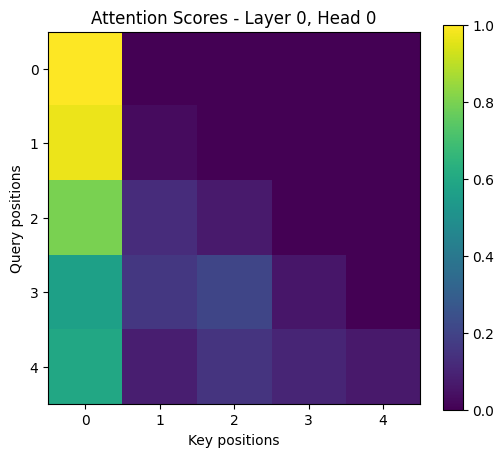

In [5]:
attention_layer_0 = all_attentions[0]  # Attention from the first transformer block
# Shape: [batch_size, n_heads, seq_len, seq_len]
print("Attention layer 0 shape:", attention_layer_0.shape)

# We'll visualize head 0
attention_head_0 = attention_layer_0[0, 0].detach().cpu().numpy()

# Plot it as a heatmap
plt.figure(figsize=(6, 5))
plt.imshow(attention_head_0, cmap="viridis")
plt.colorbar()
plt.title("Attention Scores - Layer 0, Head 0")
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.show()

In the heatmap:
- The x-axis represents the positions of the tokens as "keys".
- The y-axis represents the same tokens as "queries".
- The color intensity represents how much each query token attends to each key token in this head.

---

### 4.2. Visualizing Attention for All Layers

Now, let's visualize the attention heads from the first layer and see the differences in the heatmaps, which illustrates that each attention head in the first layer is focused on different aspects of the input sequence.

Attention layer 0 shape: torch.Size([1, 12, 5, 5])


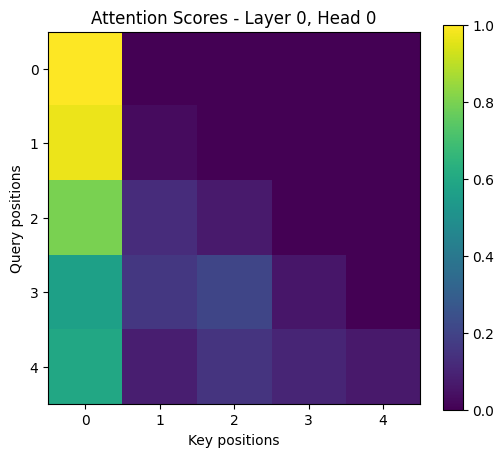

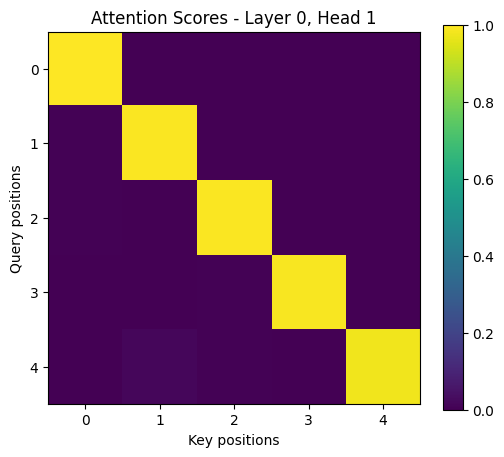

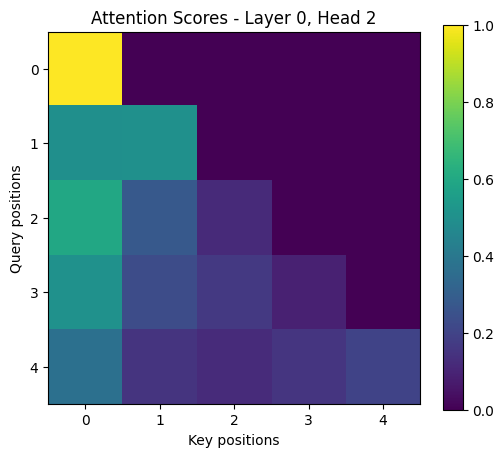

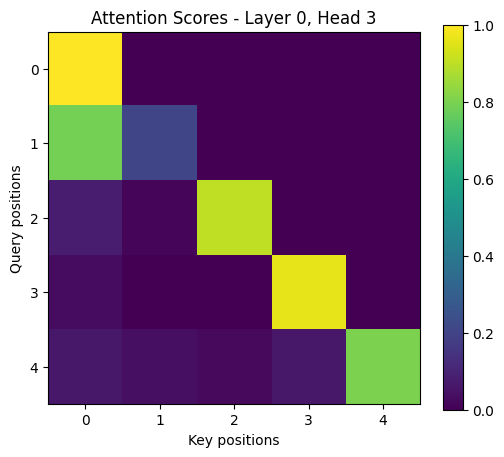

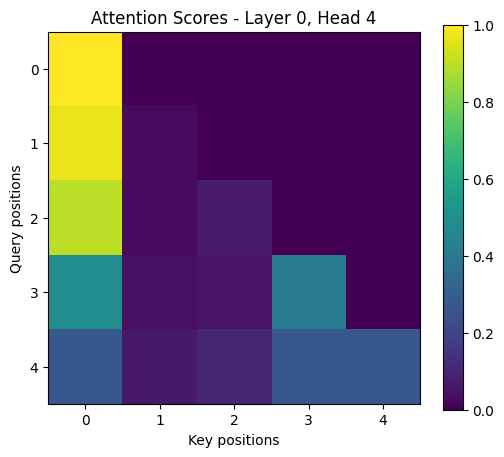

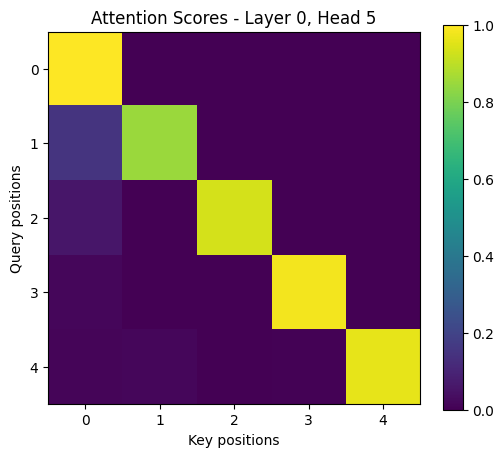

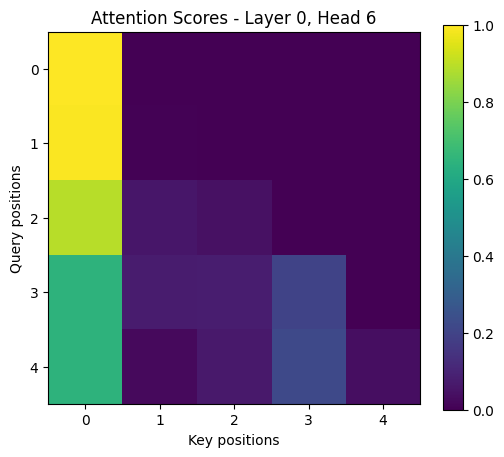

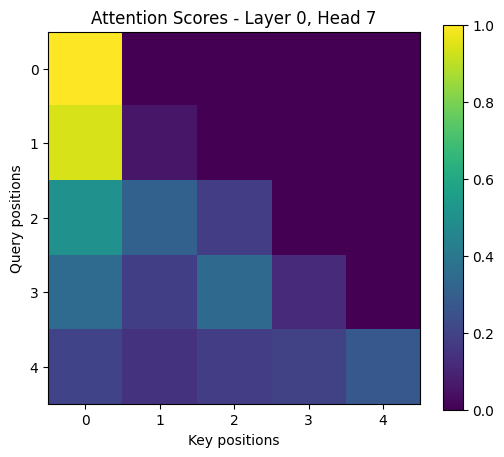

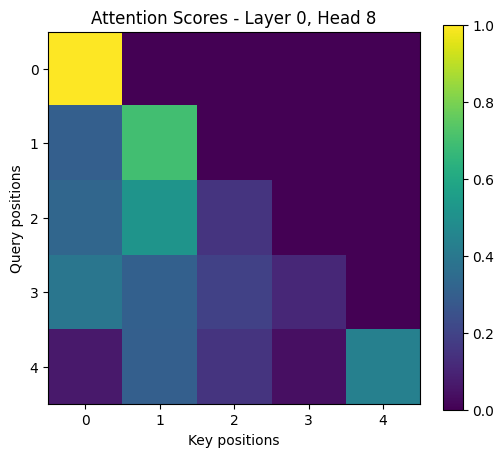

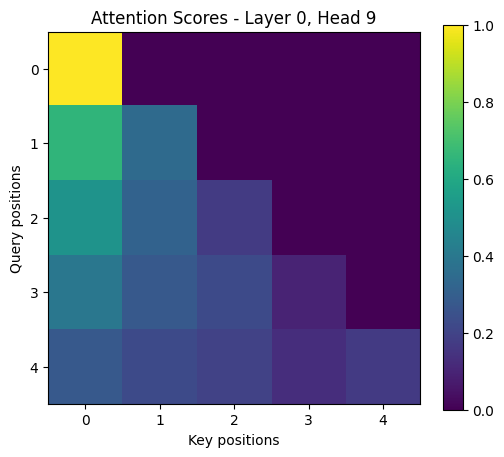

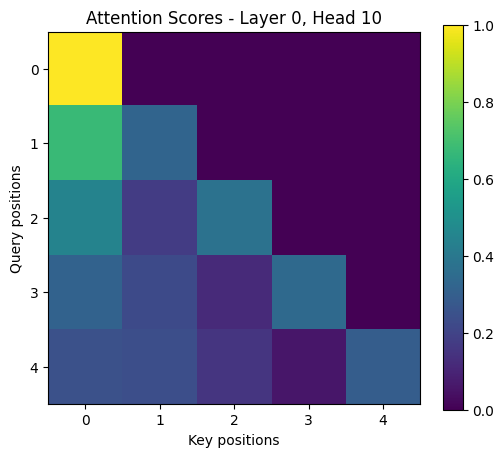

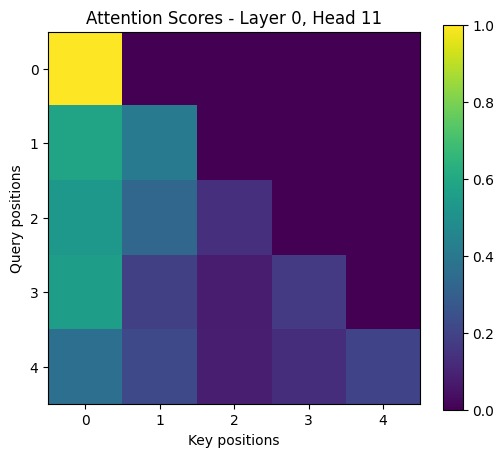

In [6]:
attention_layer_0 = all_attentions[0]  # Attention from the first transformer block
# Shape: [batch_size, n_heads, seq_len, seq_len]
print("Attention layer 0 shape:", attention_layer_0.shape)

# Visualize all attention heads in layer 0
for head_idx, attention_head in enumerate(attention_layer_0[0]):
    attention_head_detached = attention_head.detach().cpu().numpy()
    # Plot it as a heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(attention_head_detached, cmap="viridis")
    plt.colorbar()
    plt.title(f"Attention Scores - Layer 0, Head {head_idx}")
    plt.xlabel("Key positions")
    plt.ylabel("Query positions")
    plt.show()

As, we can see, each attention head is focused on a different aspect of the input sequence. What that focus may be; however, is more difficult to determine. Research has shown that some layers may be focused on:

- Syntactic/Grammatical Relationships (subject-verb agreement, tokens that disambiguate case or tense, etc.)
- Coreference Resolution (connecting a pronouns to their antecedents)
- Position or Structural Boundaries (sentences, puncation, etc.)
- Named Entities or Important Keywords
- Long Range Dependencies (some heads may focus on tokens that are skipping further away in text to pick out distant, relevant words)
- Self-Reference (other heads may attend to the token, itself, to pass on its information verbatim)
- Whitespace/Formatting Tokens (paragraphs, special separators, etc.)
- Common Colocations/Phrasing (heads may learn to link certain tokens together that appear frequently together)

In some cases it has been noted that:

- Lower layers focus on more basic, structural patterns (punctuation, short-distance dependencies, and sub-word patterns)
- Higher layers focus on more abstract, semantic, or global relationships (topic coherence, advanced grammatical structure, and discourse-level patterns)

These are not strict rules, but observations from on-going interpretability research.

Now, let's go ahead and show the attention heatmaps for all heads in all layers.

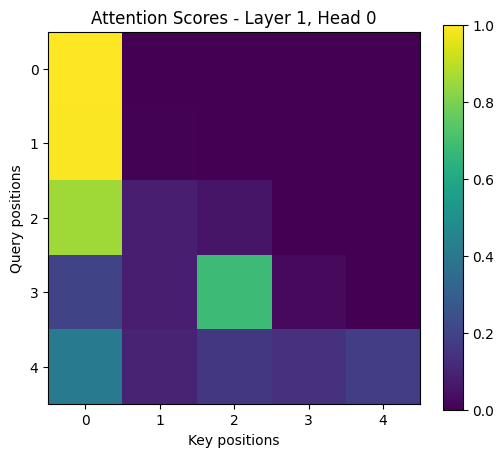

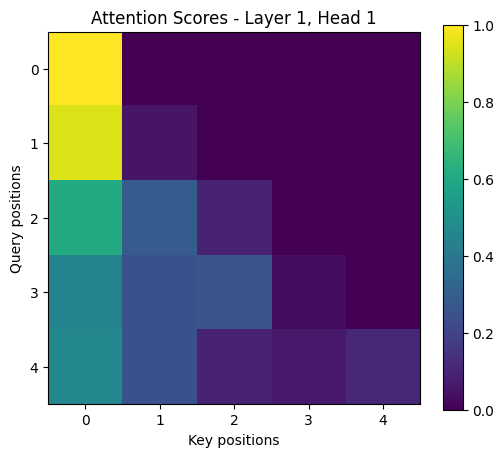

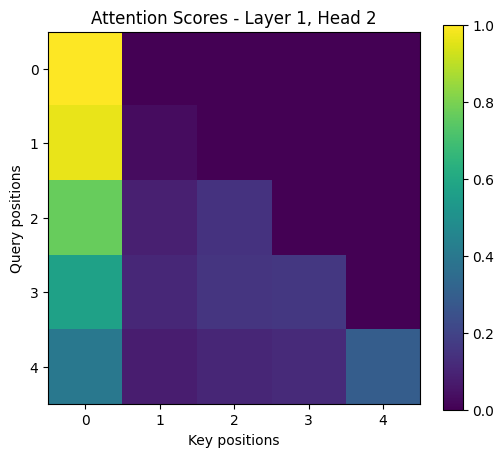

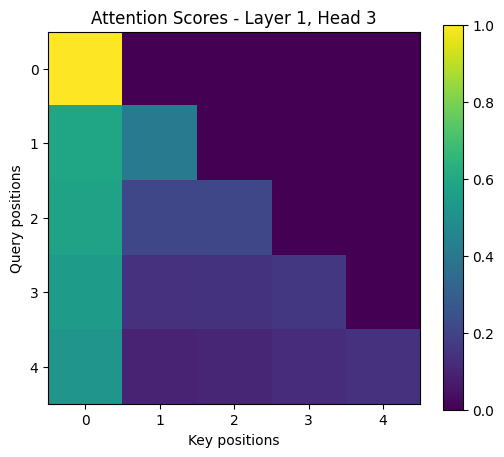

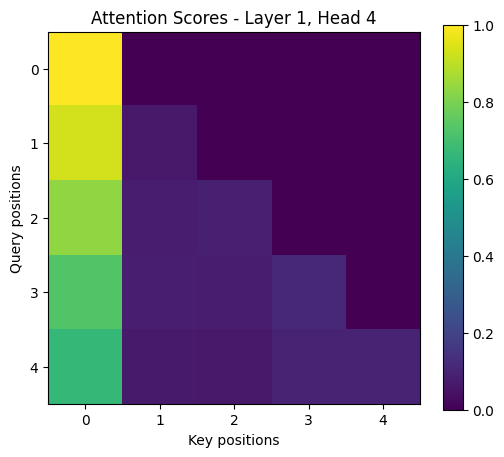

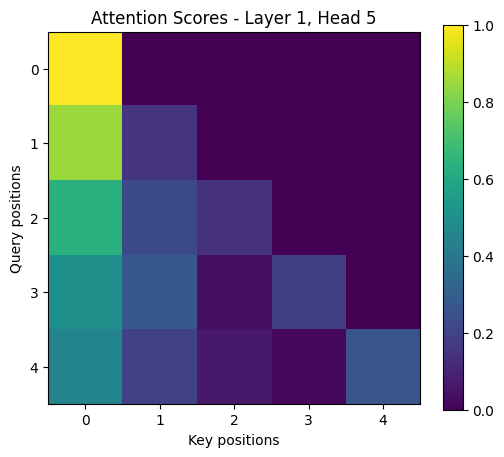

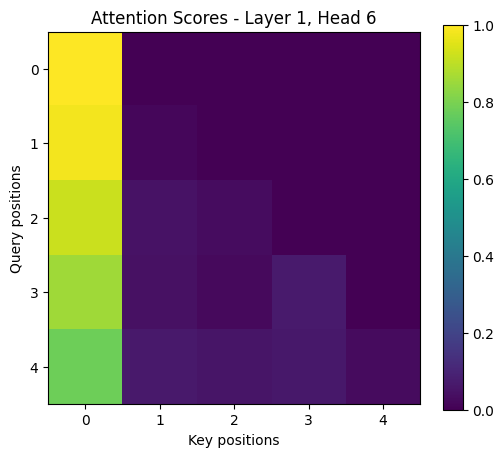

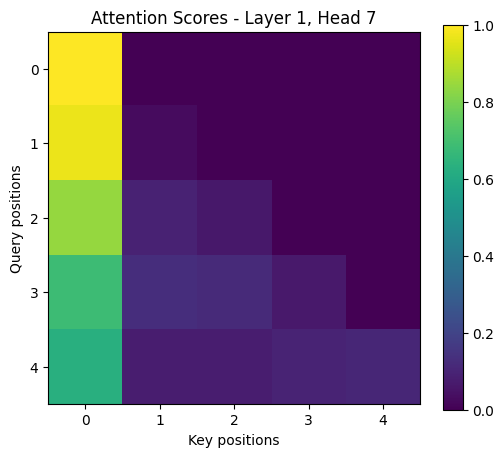

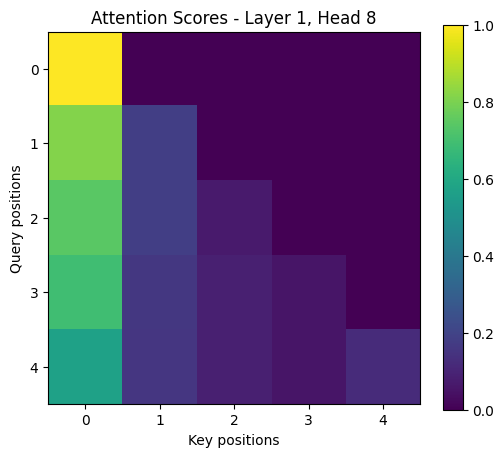

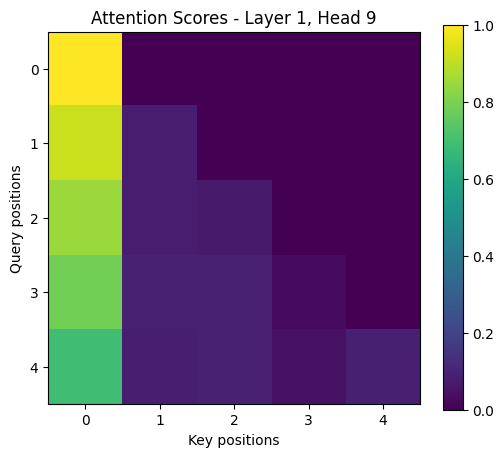

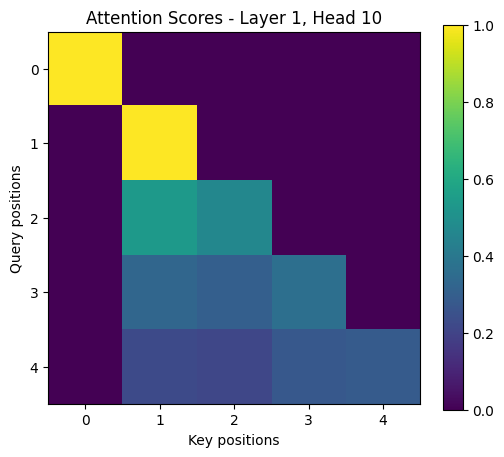

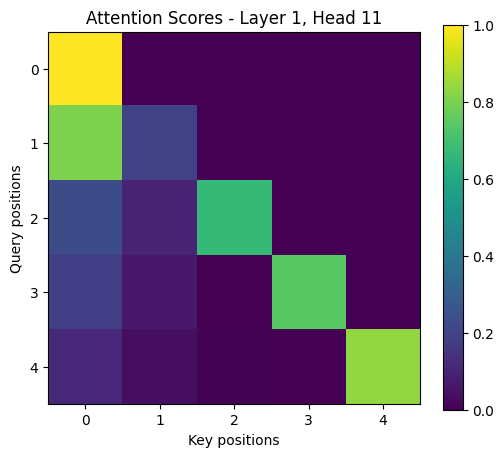

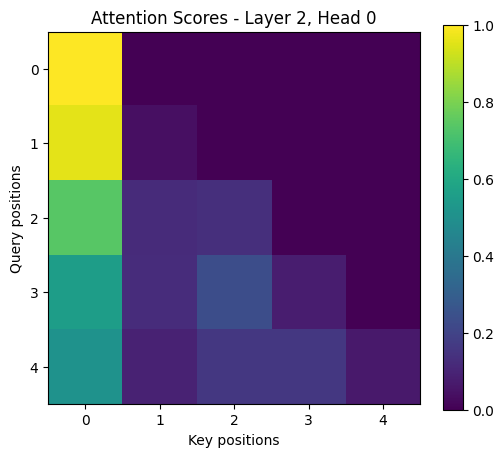

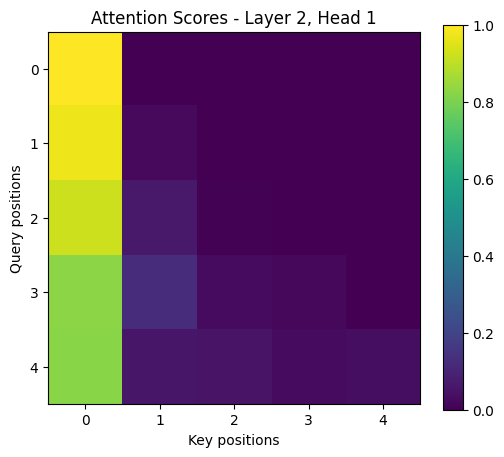

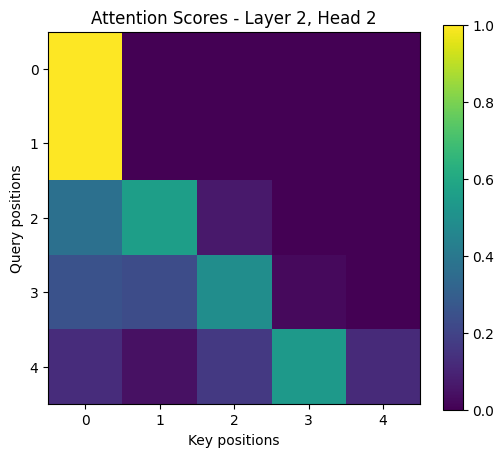

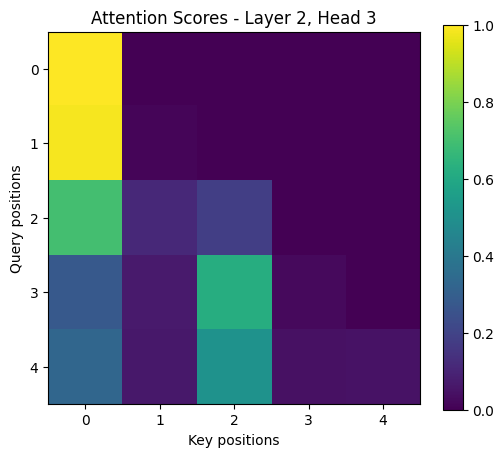

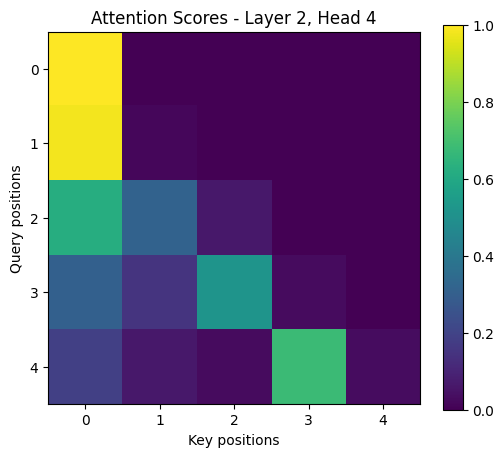

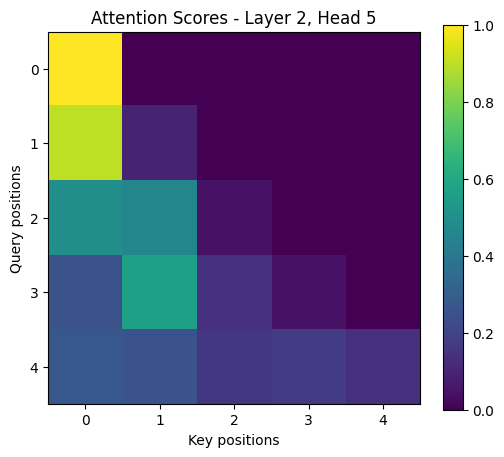

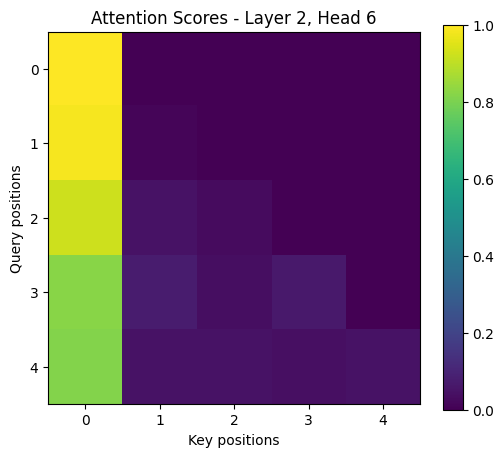

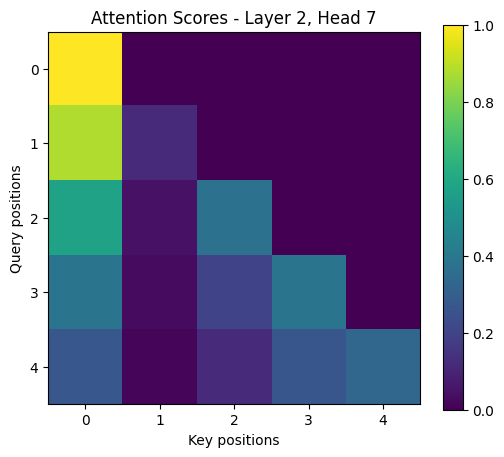

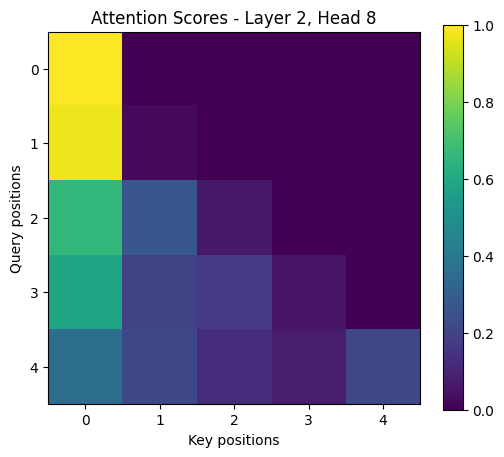

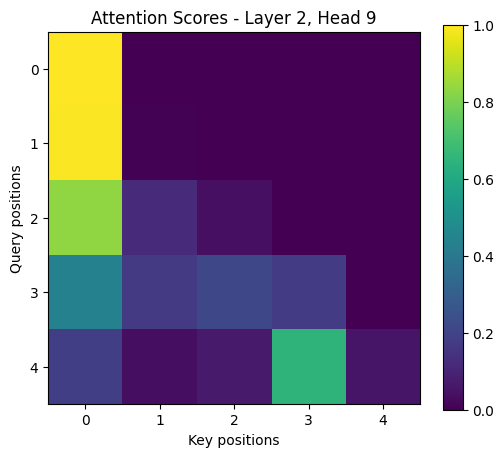

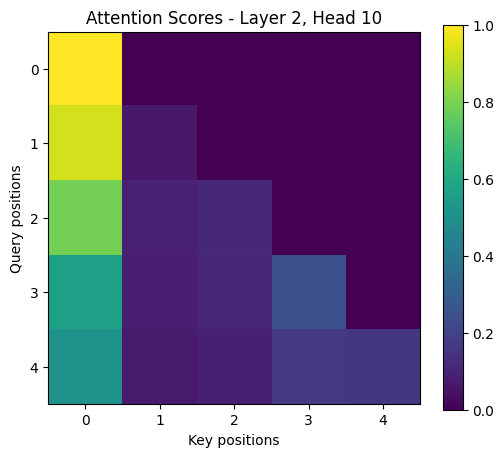

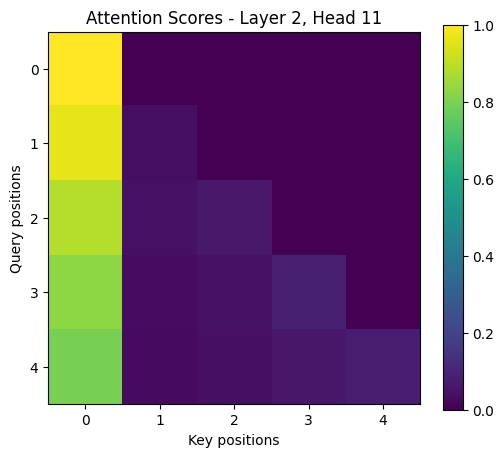

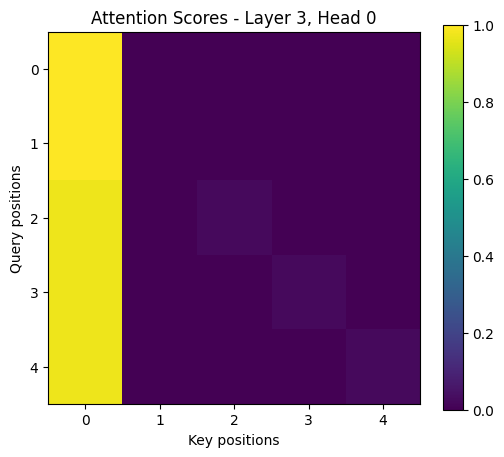

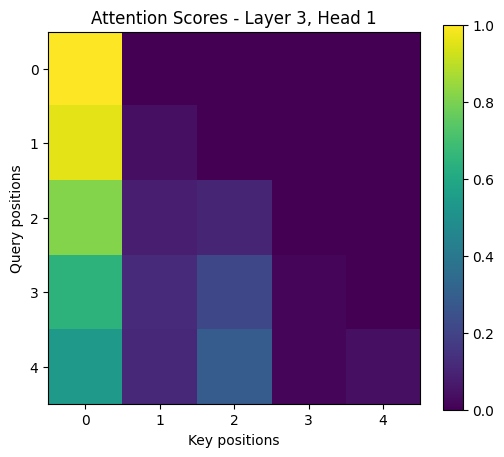

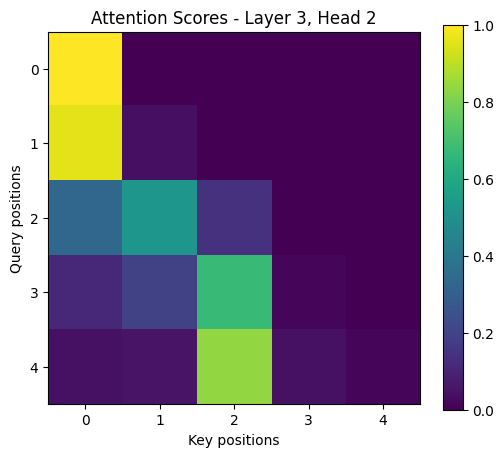

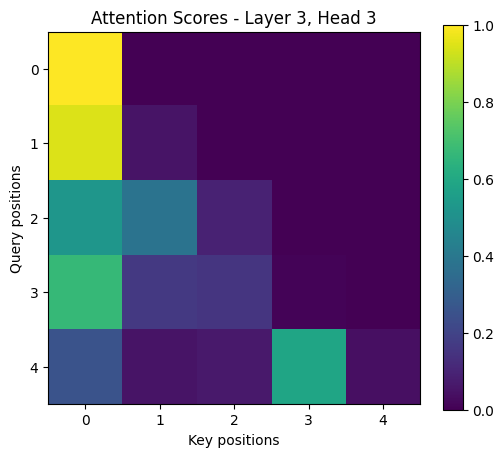

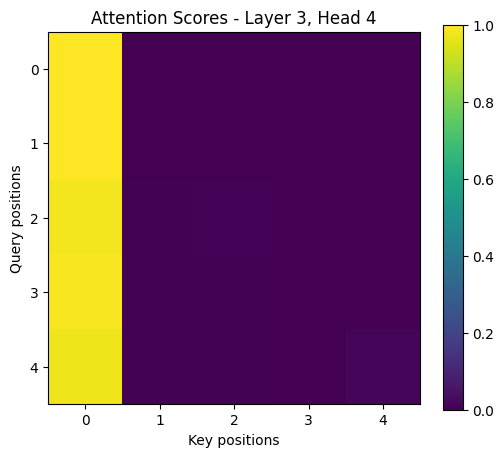

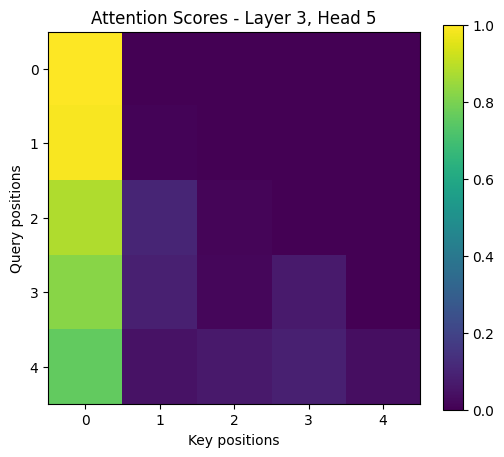

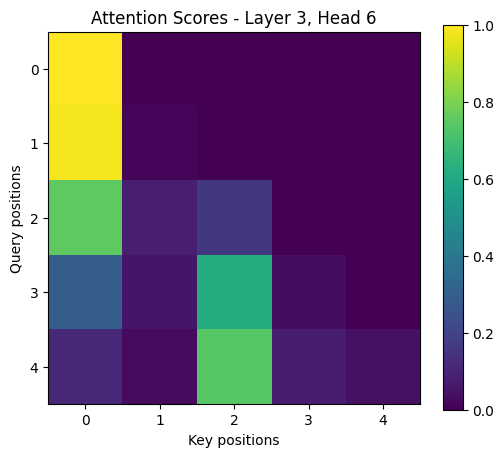

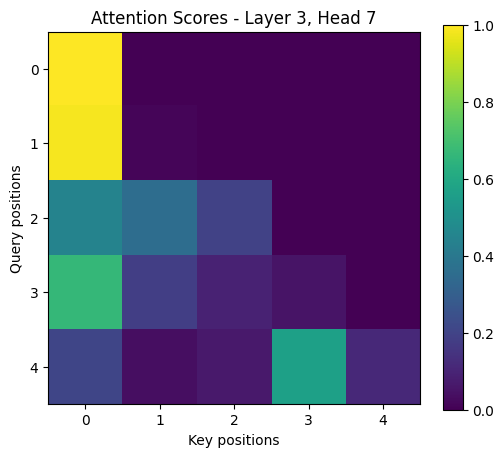

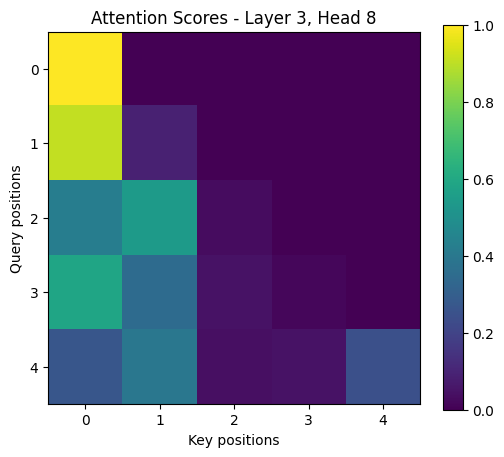

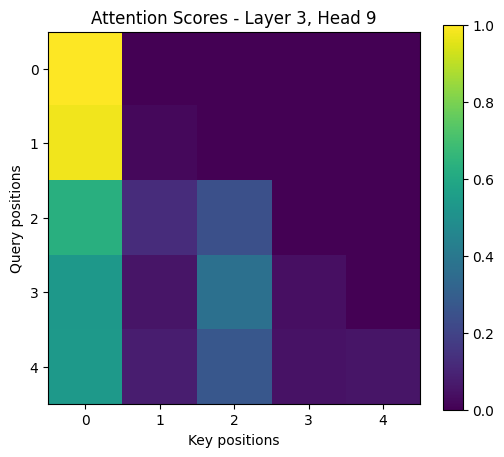

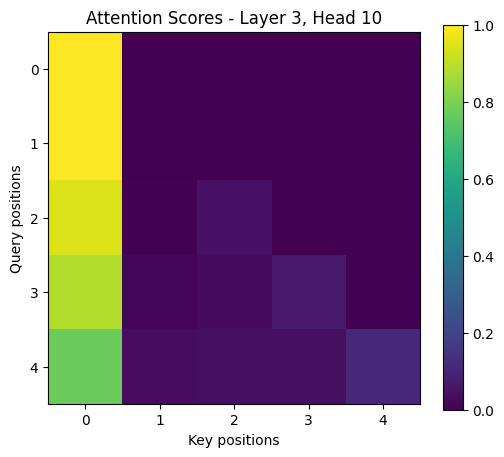

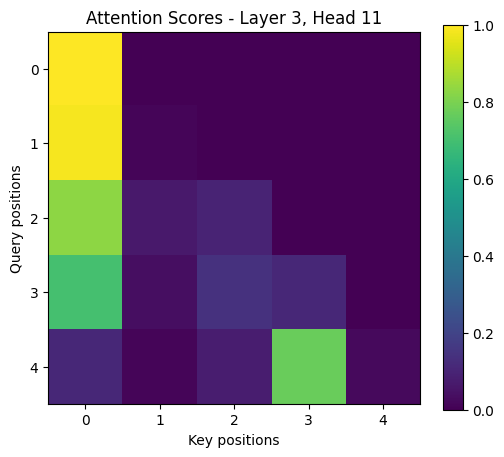

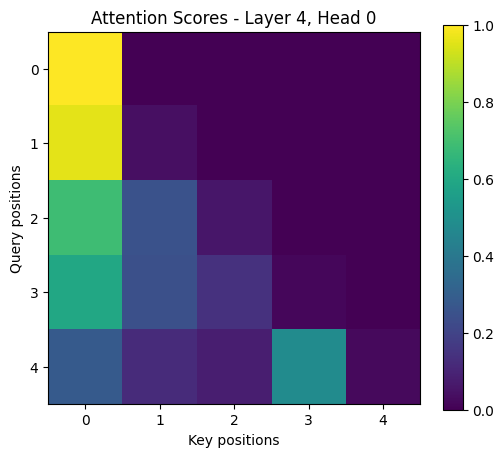

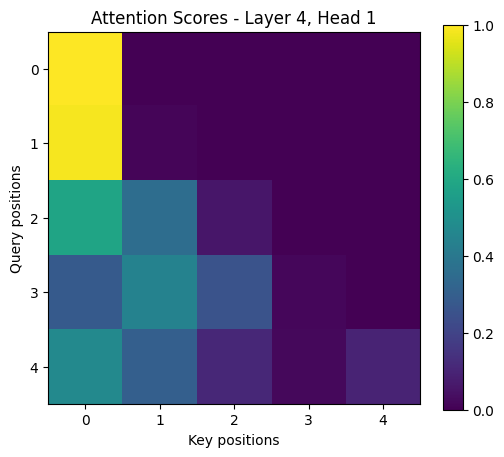

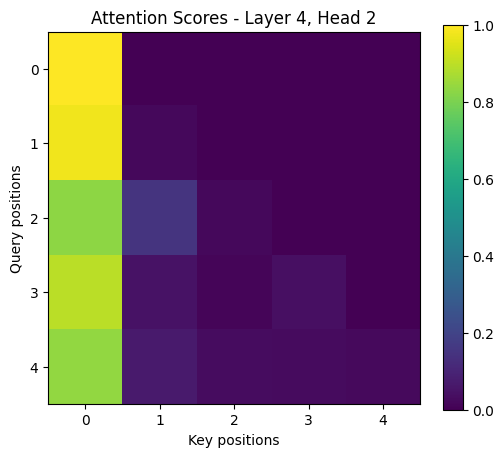

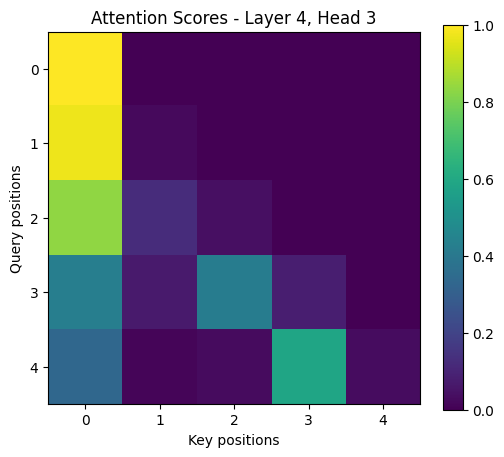

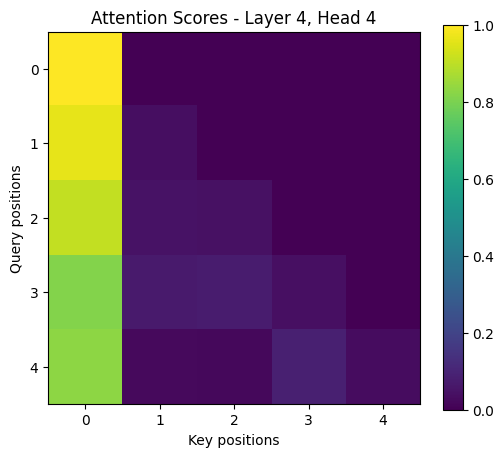

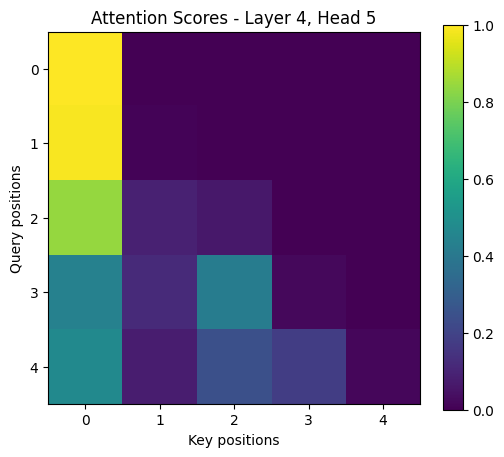

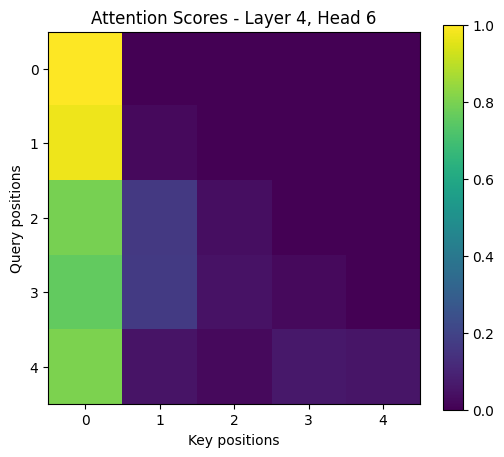

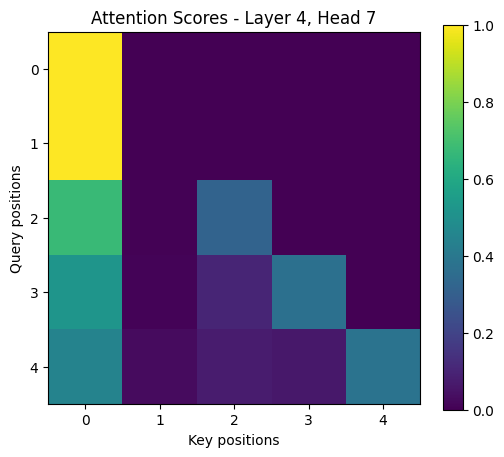

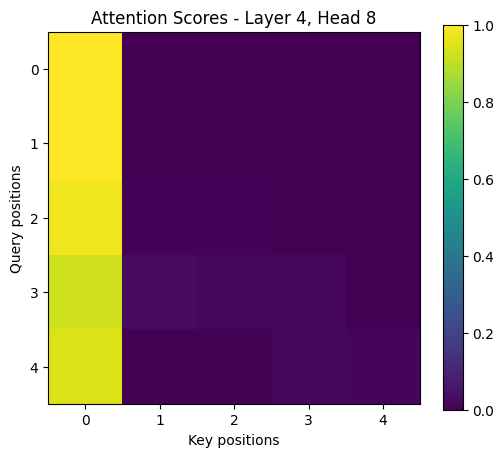

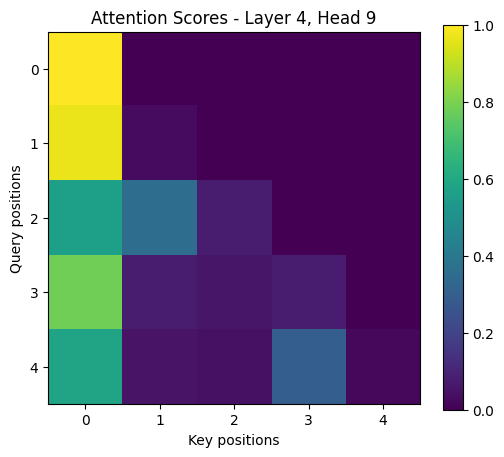

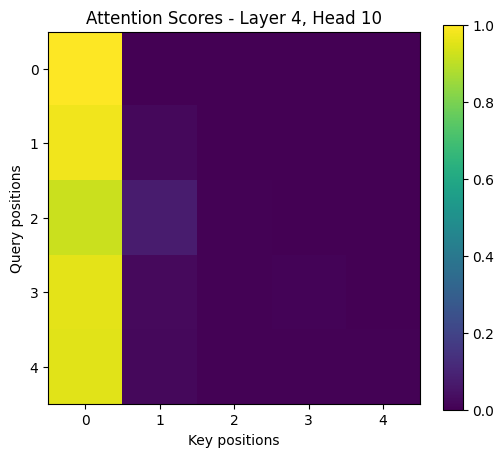

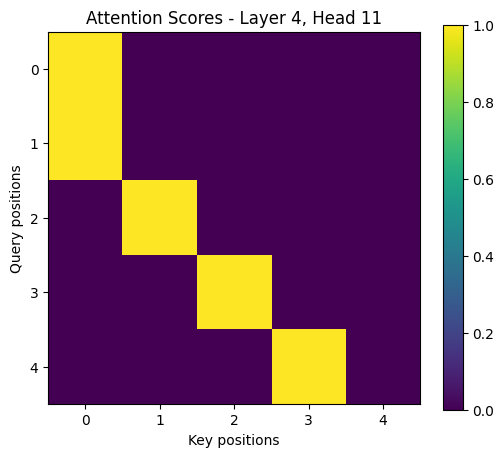

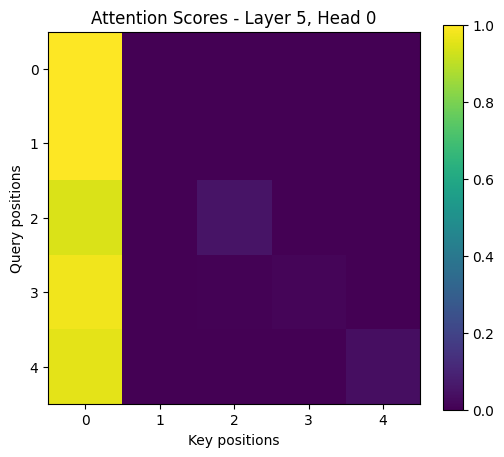

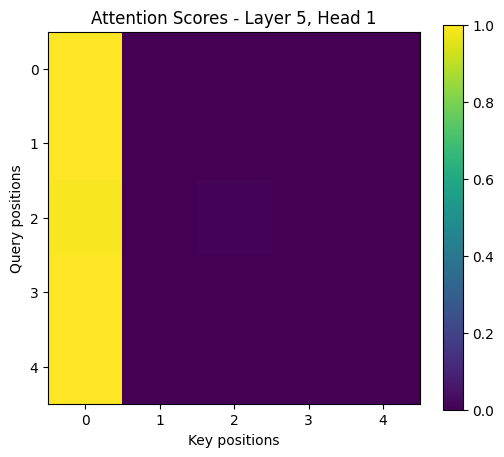

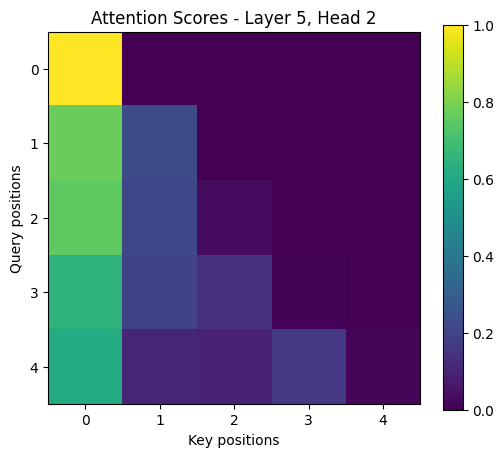

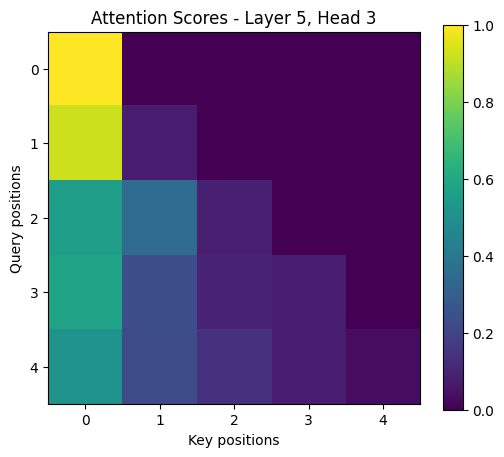

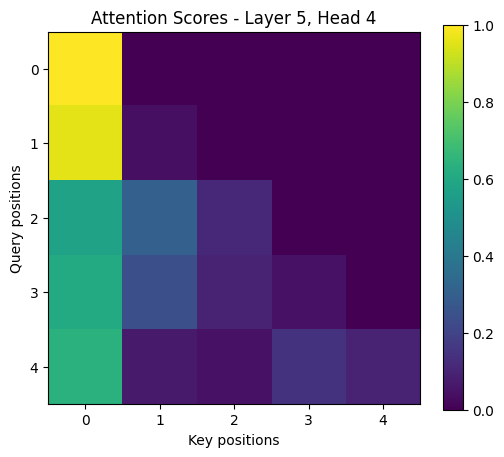

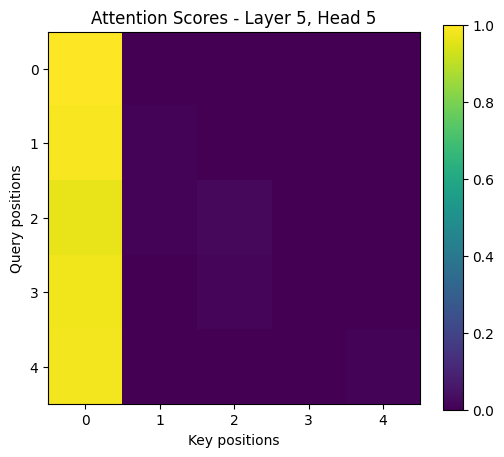

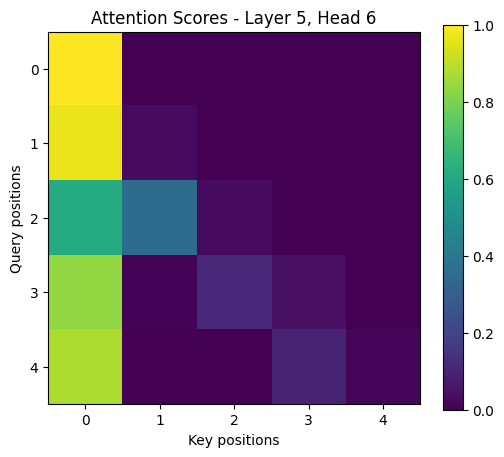

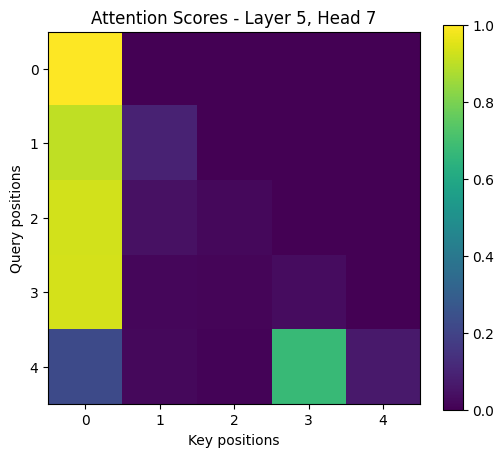

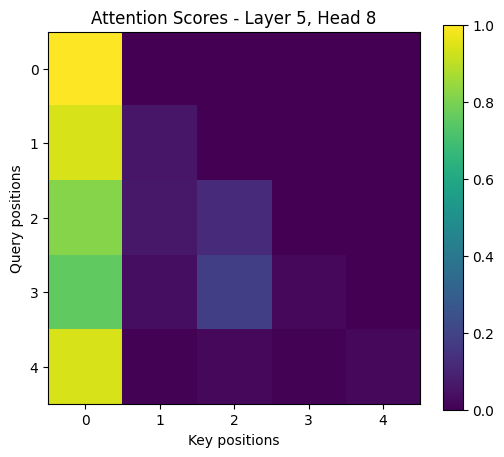

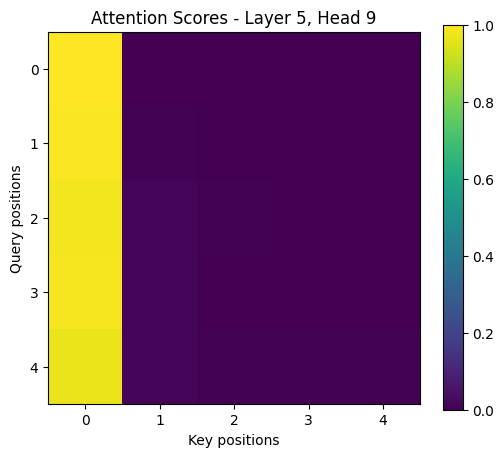

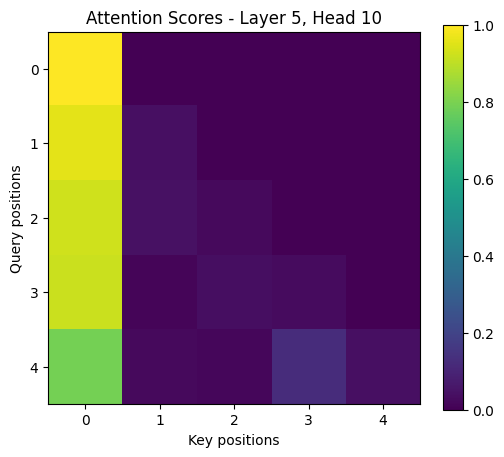

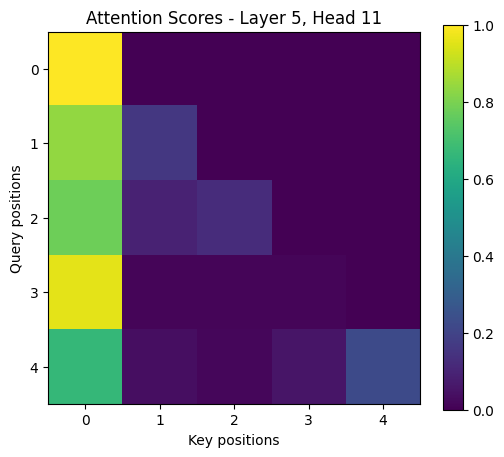

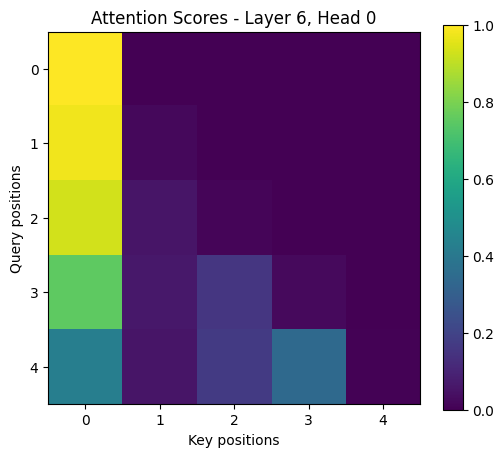

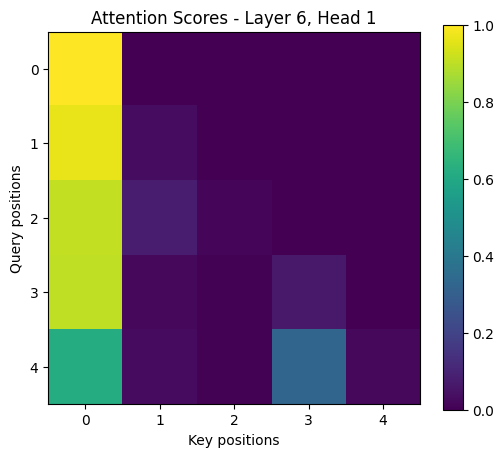

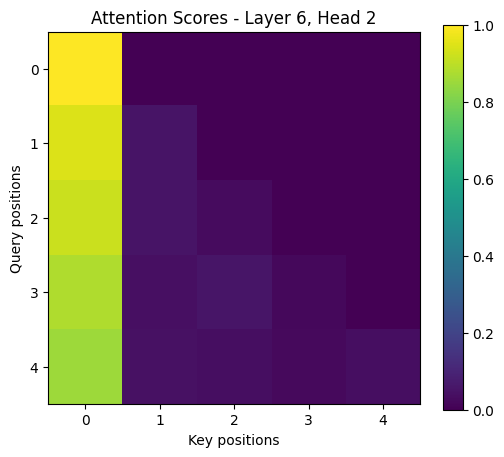

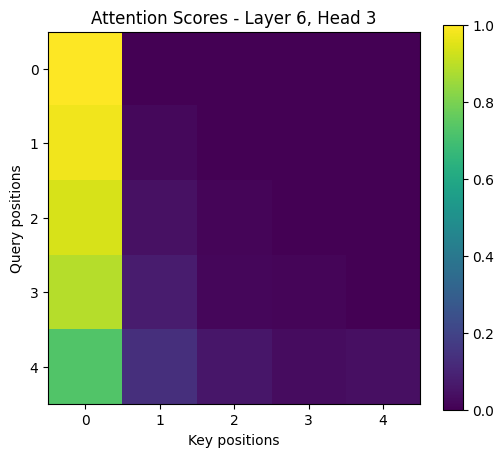

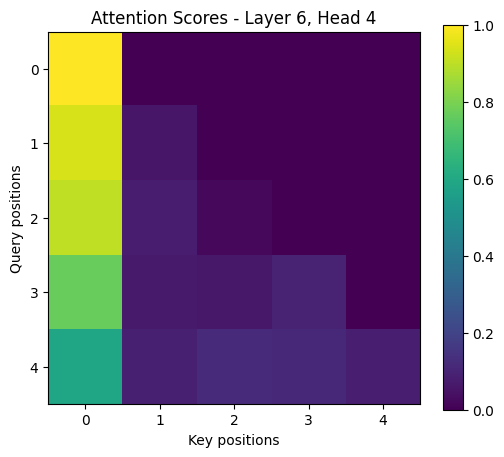

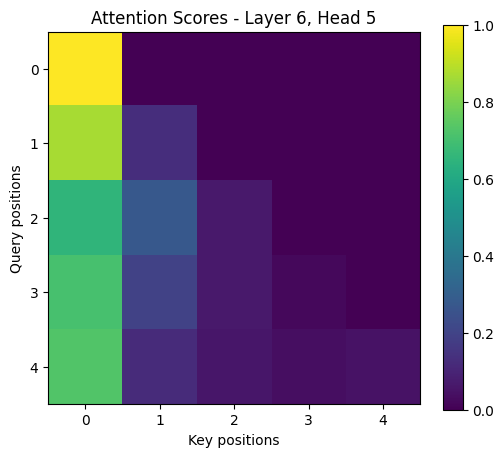

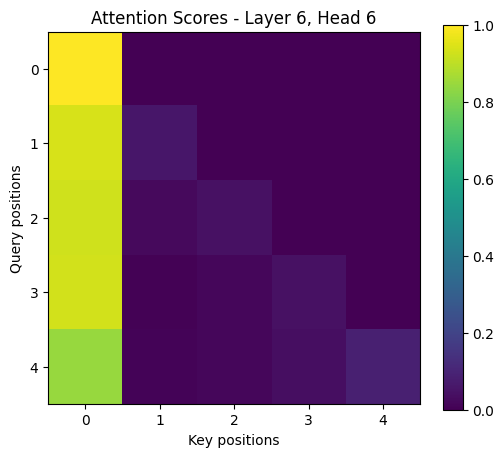

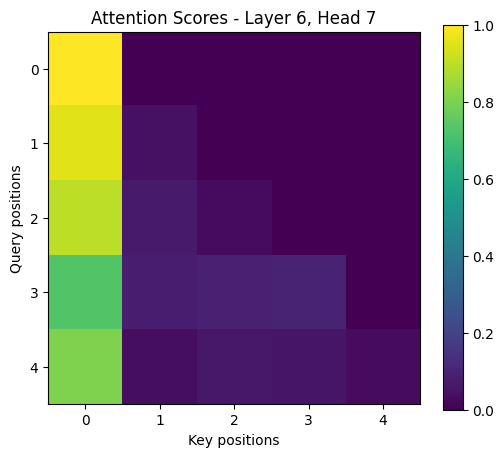

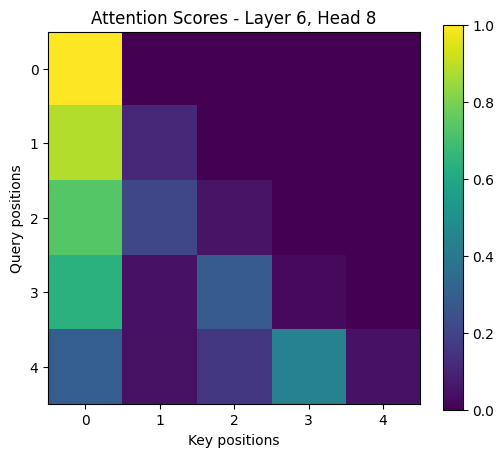

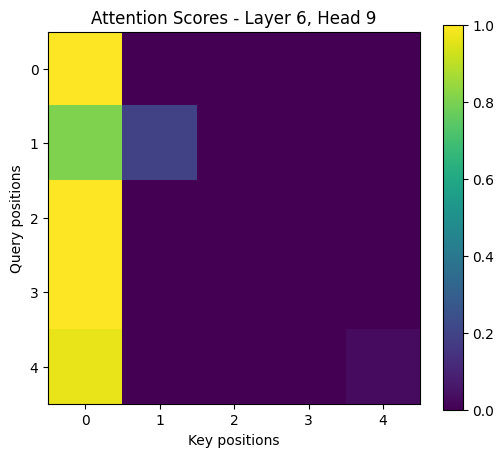

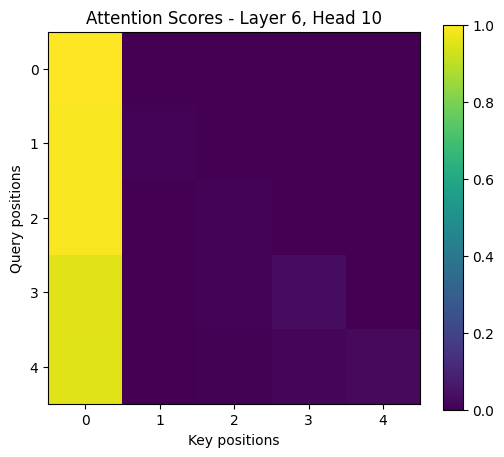

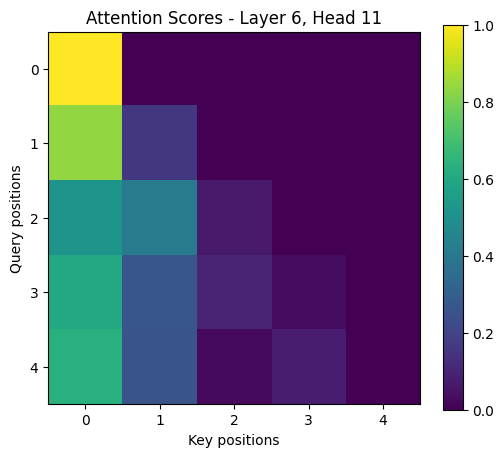

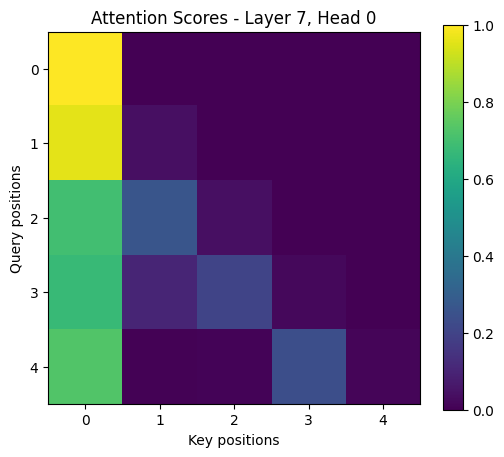

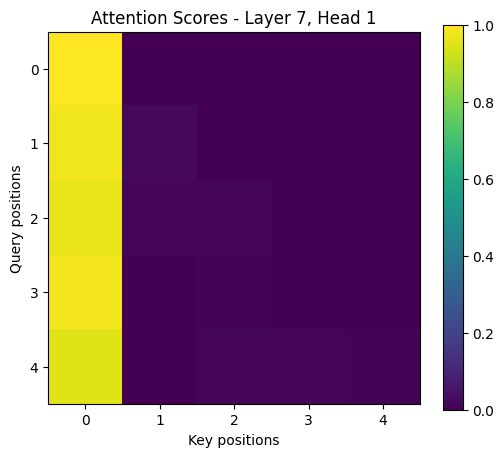

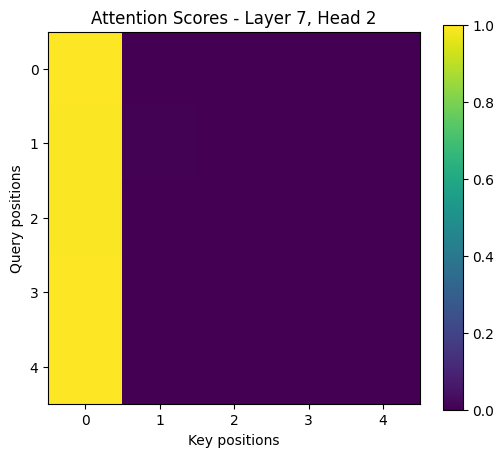

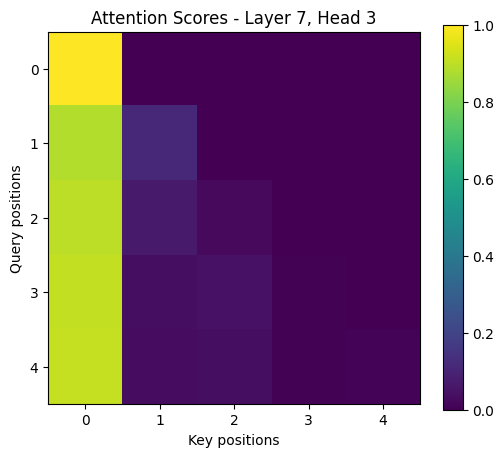

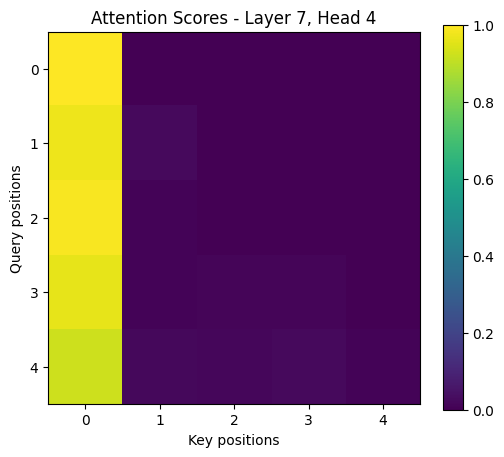

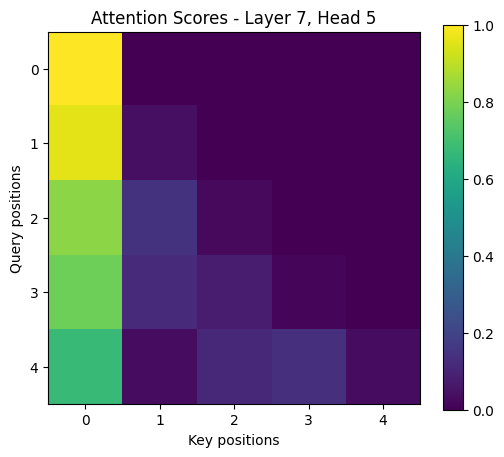

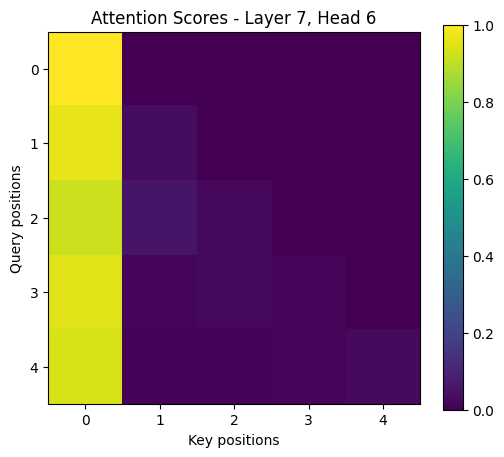

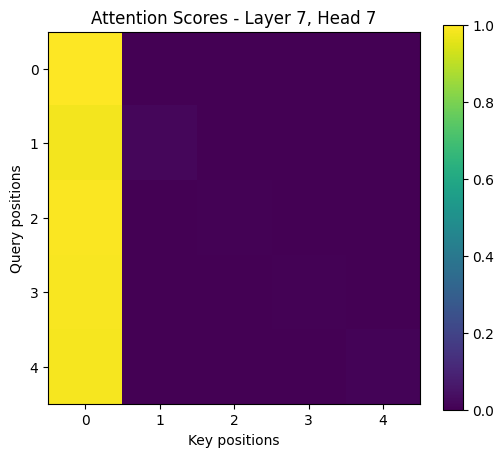

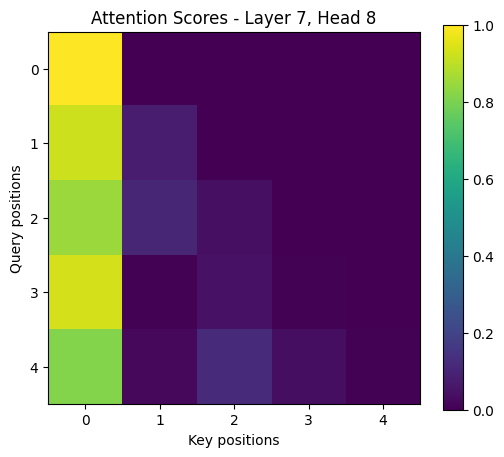

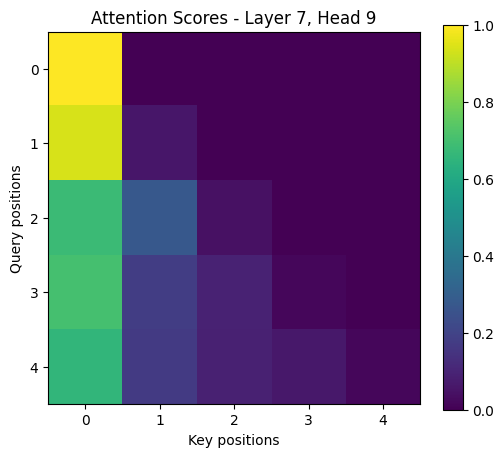

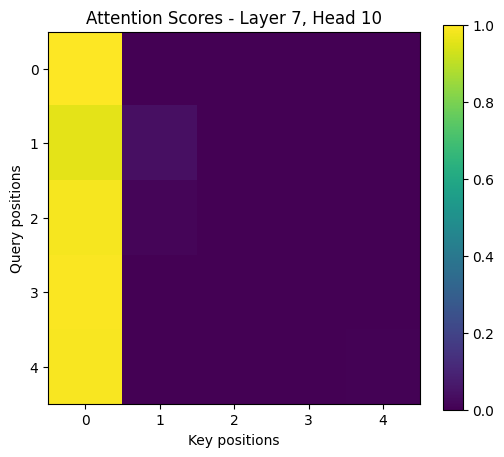

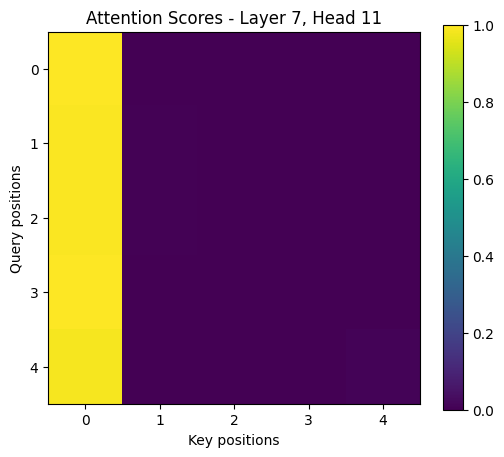

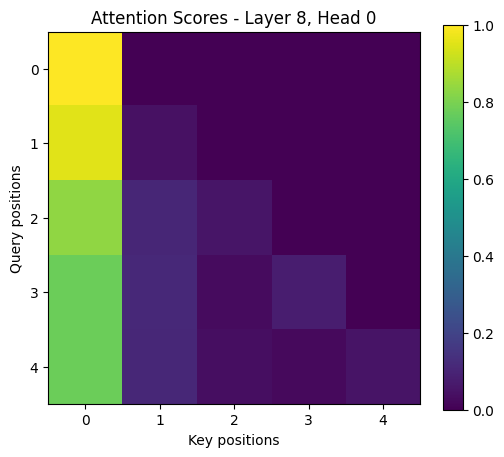

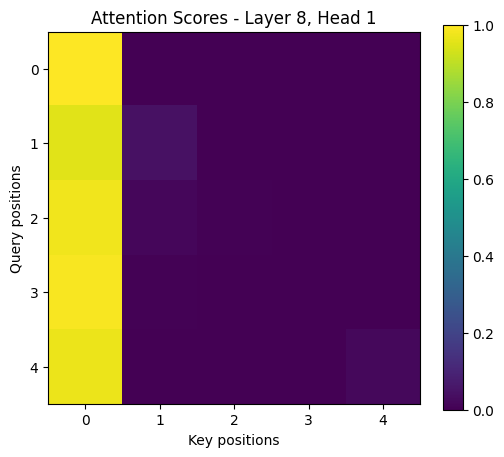

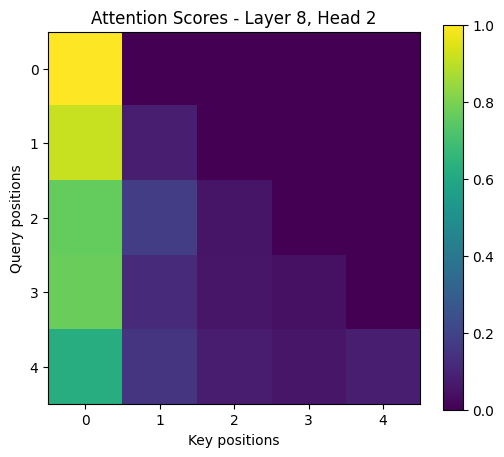

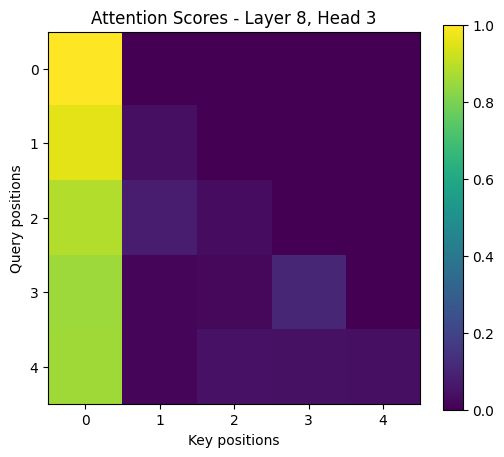

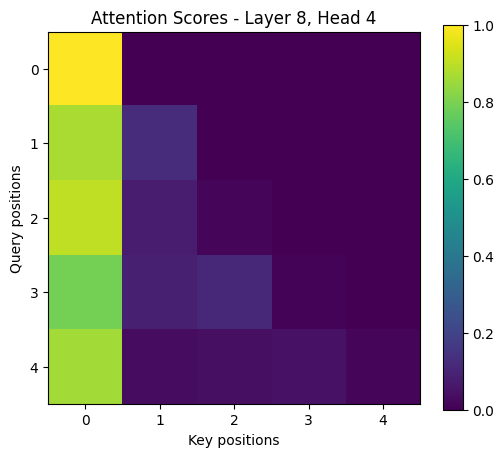

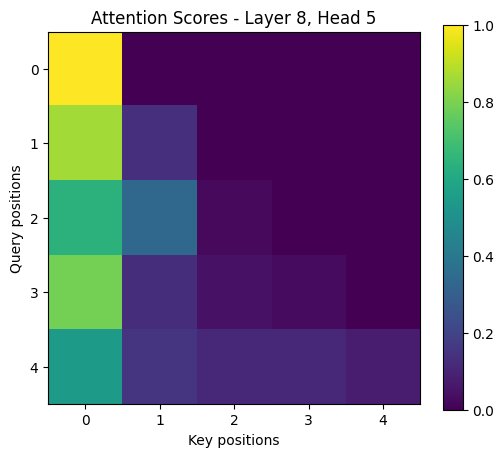

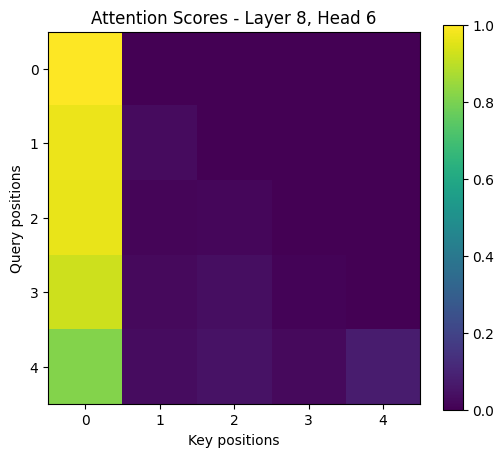

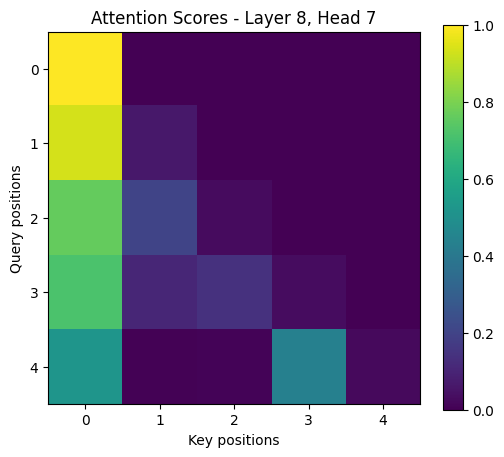

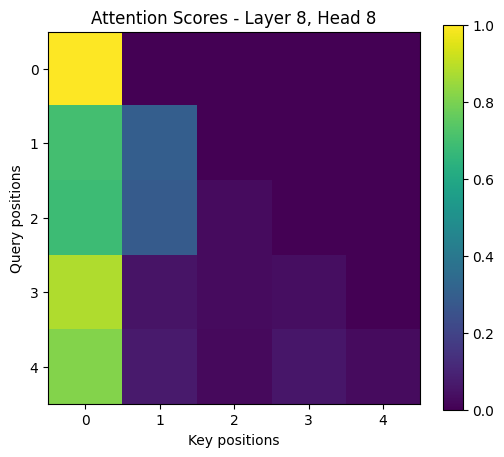

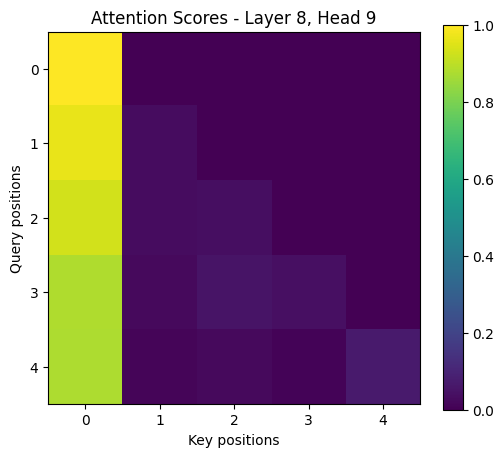

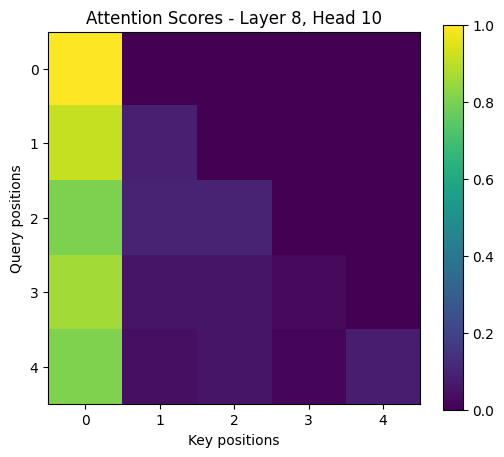

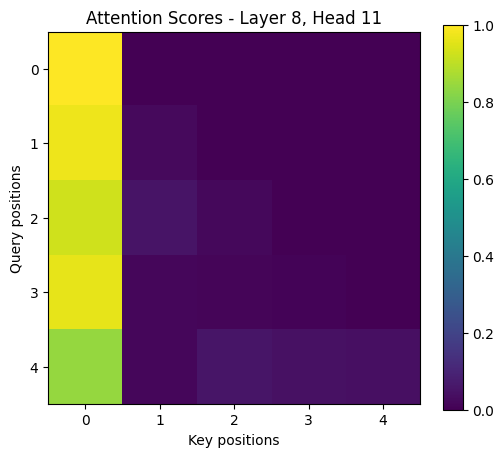

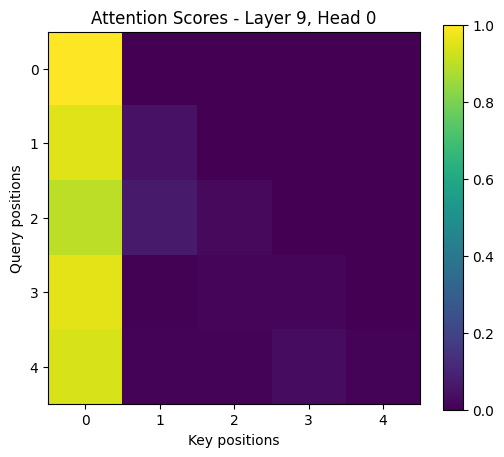

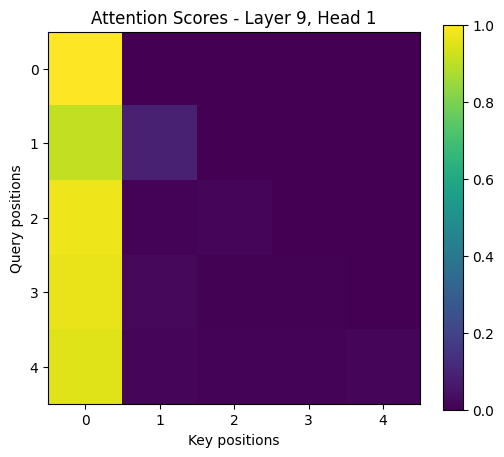

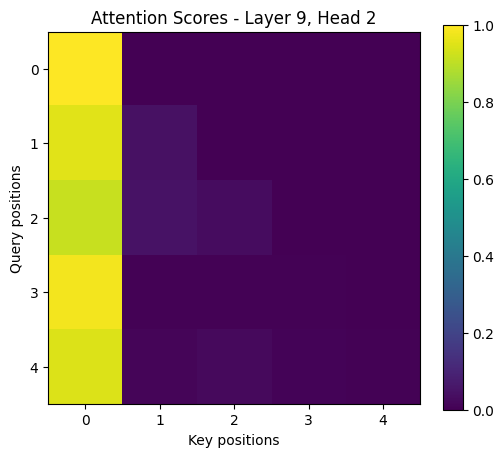

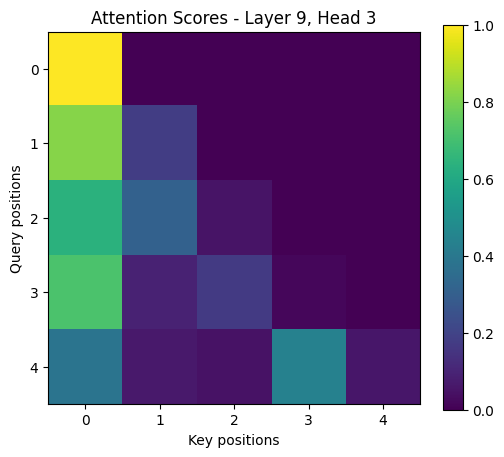

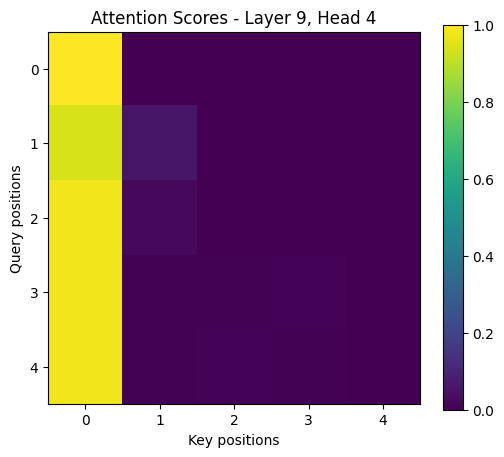

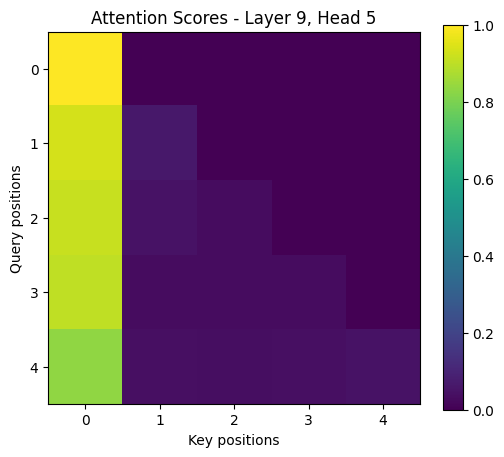

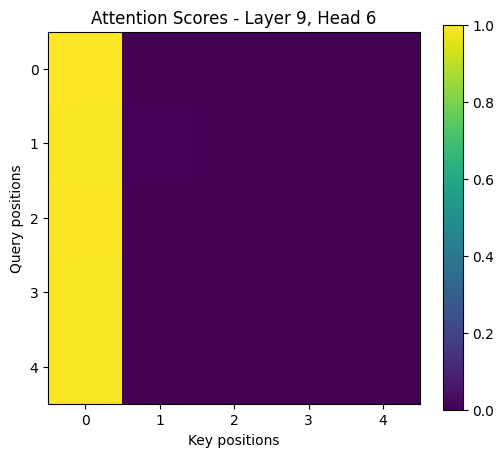

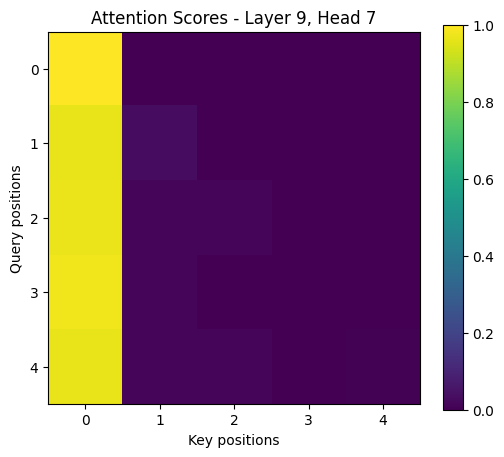

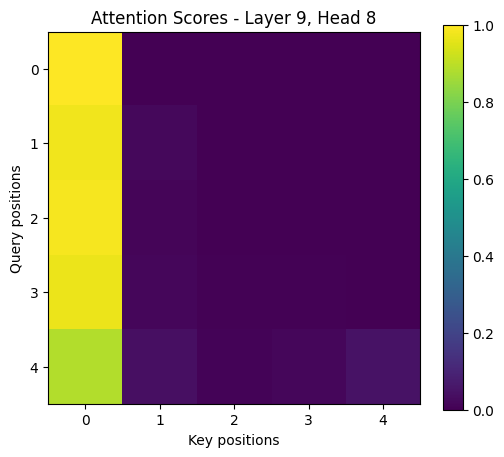

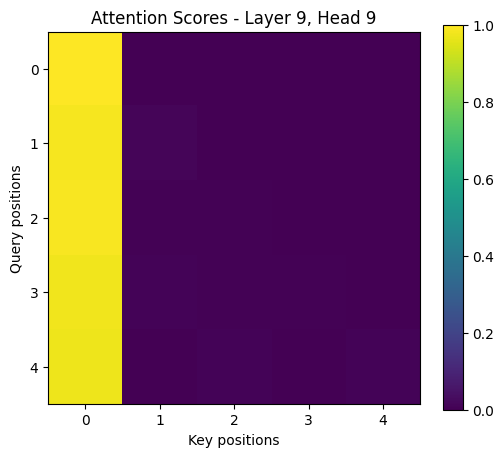

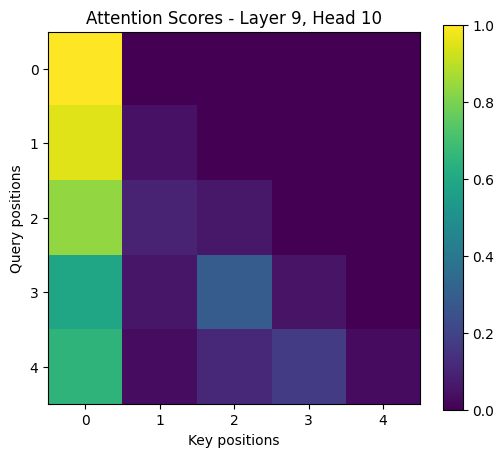

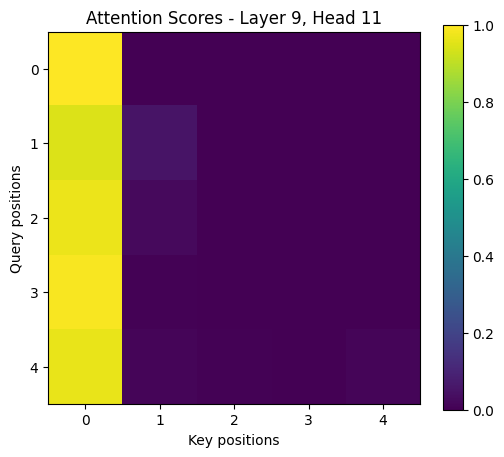

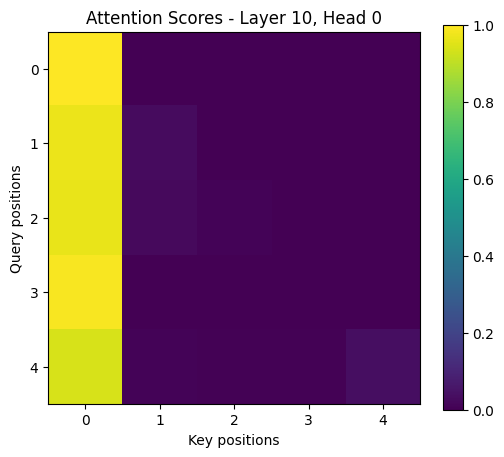

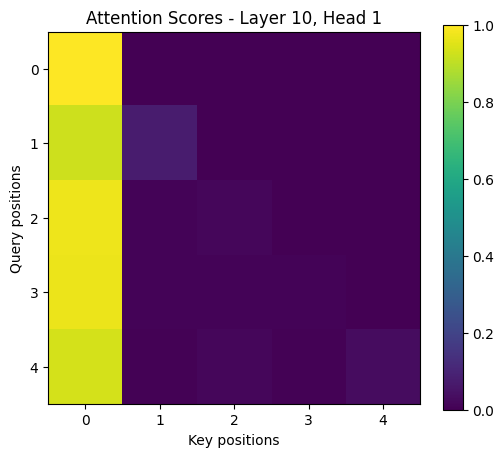

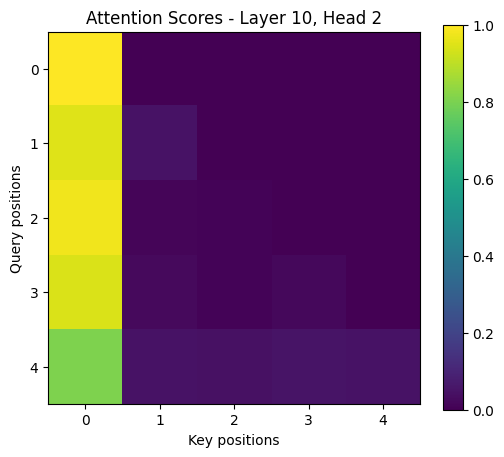

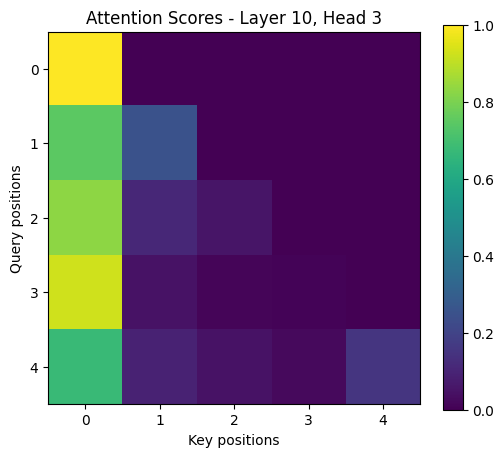

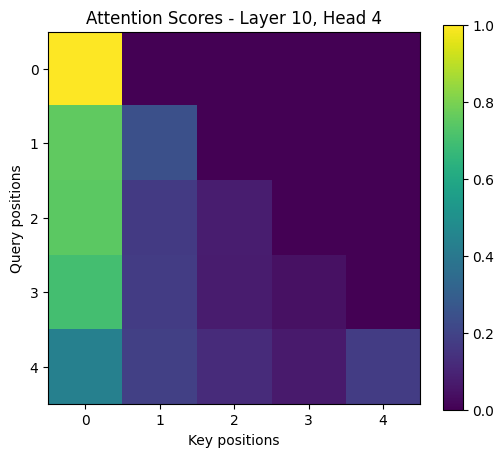

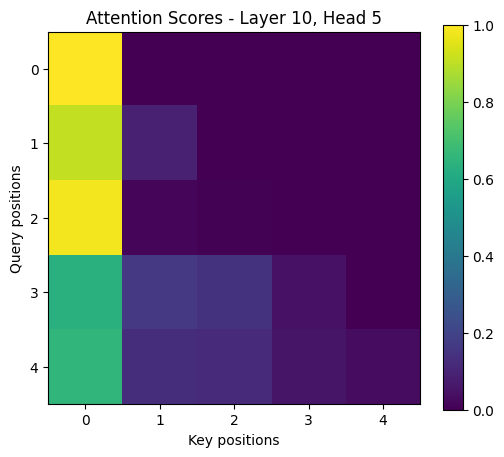

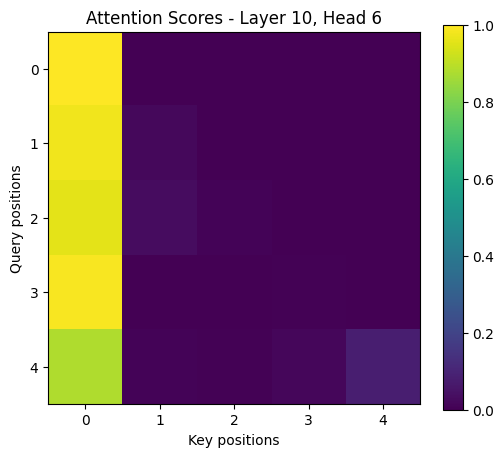

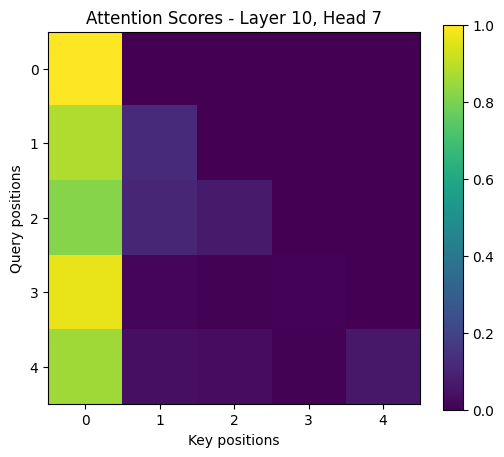

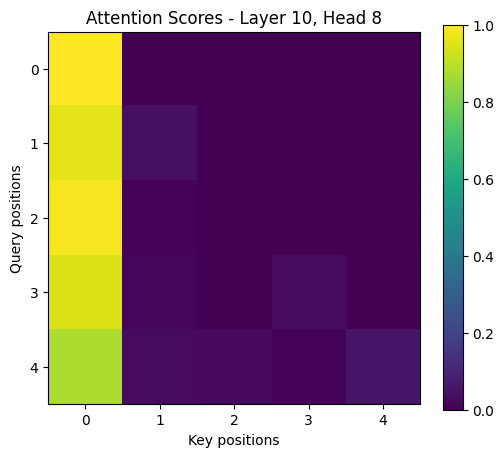

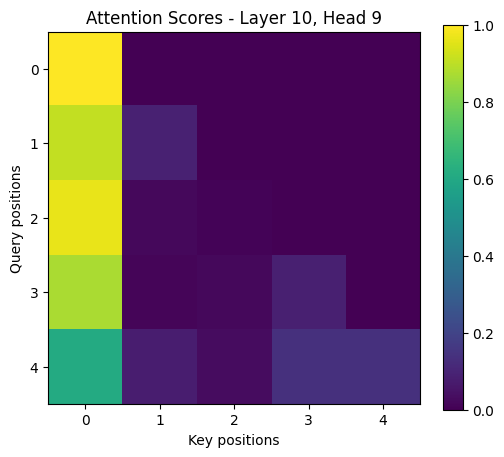

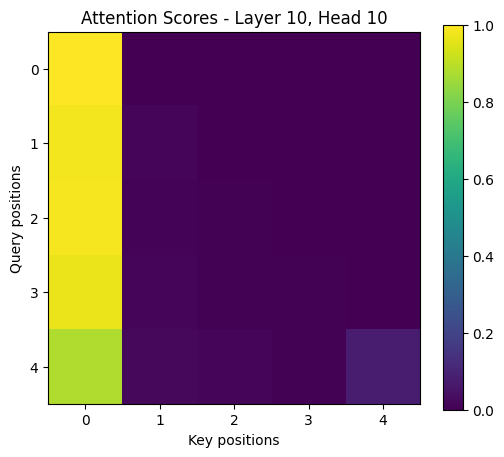

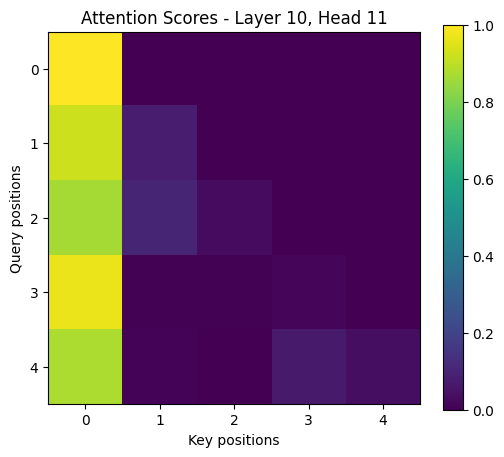

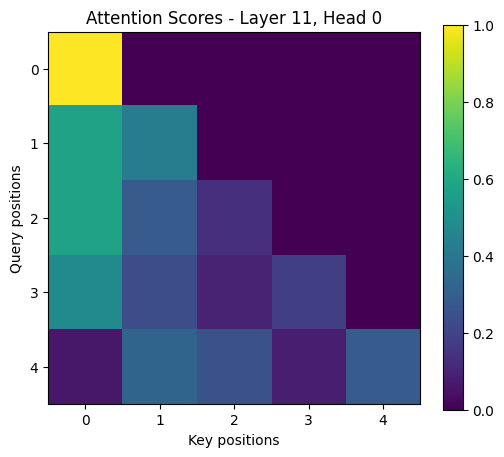

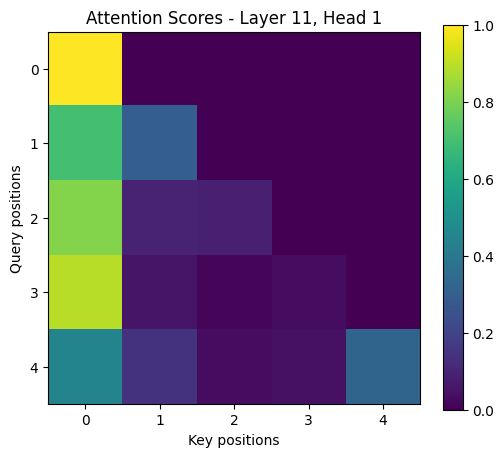

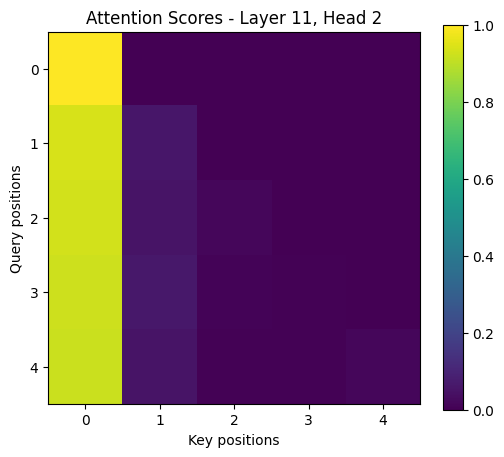

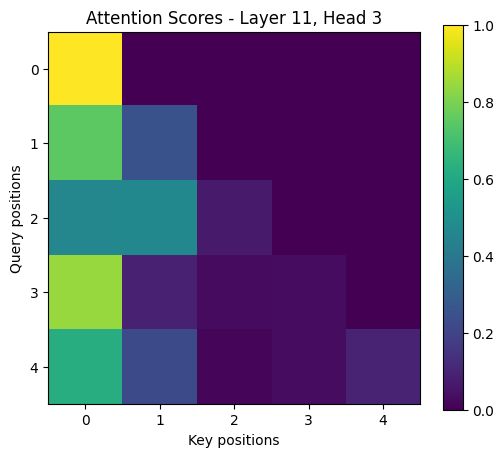

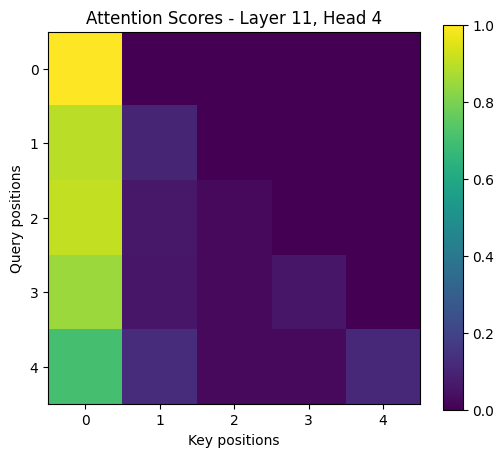

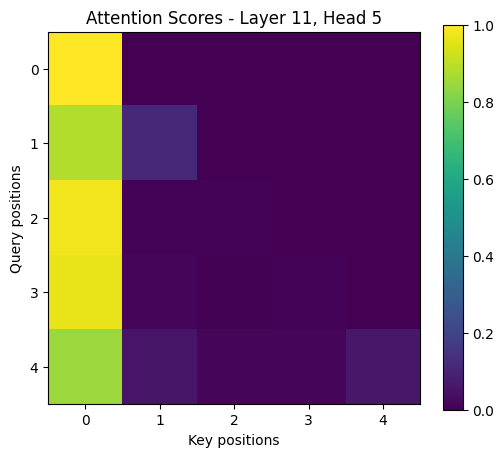

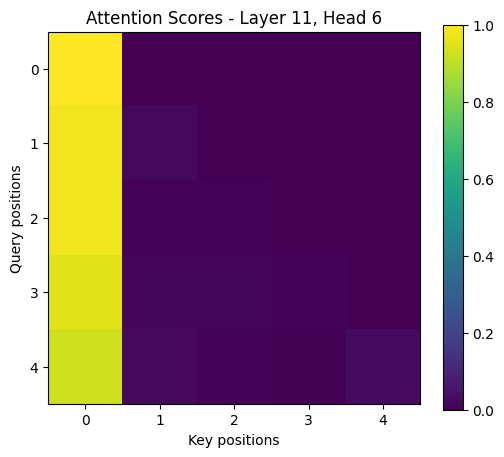

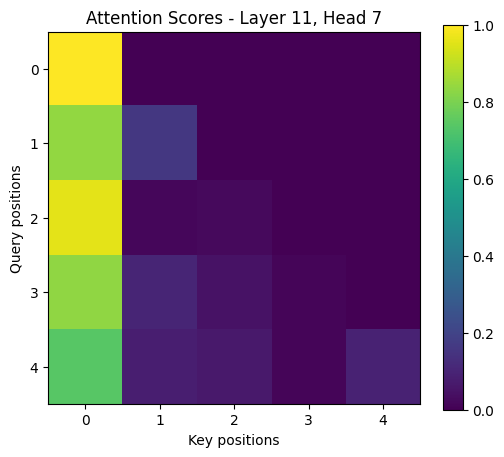

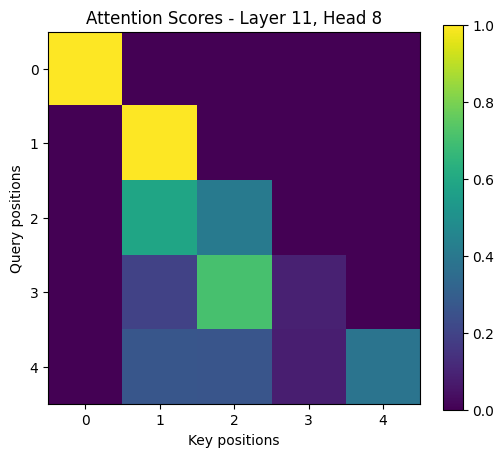

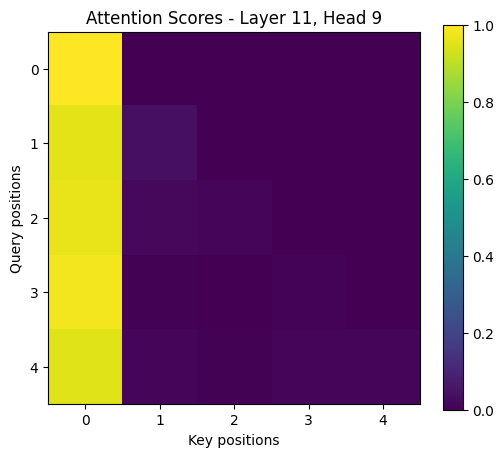

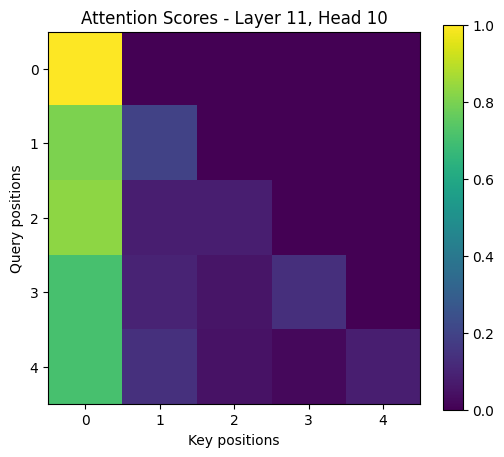

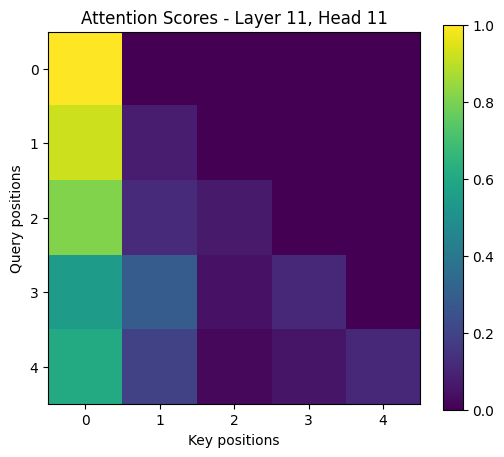

In [7]:
# Visualize attention heads for layer 1 through layer n
next_attention_layers = all_attentions[1:]  # skip the first layer (index = 0)

for layer_idx, layer_attentions in enumerate(next_attention_layers, start=1):
    # layer_attentions has shape [batch_size, n_heads, seq_len, seq_len]
    # We'll use the first batch (index 0) for visualization
    heads_for_this_layer = layer_attentions[0]

    # Now iterate over each head
    for head_idx in range(heads_for_this_layer.shape[0]):
        attention_head = heads_for_this_layer[head_idx]
        attention_head_np = attention_head.detach().cpu().numpy()

        plt.figure(figsize=(6, 5))
        plt.imshow(attention_head_np, cmap="viridis")
        plt.colorbar()
        plt.title(f"Attention Scores - Layer {layer_idx}, Head {head_idx}")
        plt.xlabel("Key positions")
        plt.ylabel("Query positions")
        plt.show()

---

## 5. Feed-Forward Layer Insights

Each Transformer block also has a feed-forward network (FFN) that processes each token's representation independently (after attention is computed). While we don't visualize it directly, we can observe its effect on the hidden states.

Check the hidden states after each layer:

In [12]:
for i, hidden_state in enumerate(all_hidden_states):
    print(f"Layer {i} hidden state shape: {hidden_state.shape}")

Layer 0 hidden state shape: torch.Size([1, 5, 768])
Layer 1 hidden state shape: torch.Size([1, 5, 768])
Layer 2 hidden state shape: torch.Size([1, 5, 768])
Layer 3 hidden state shape: torch.Size([1, 5, 768])
Layer 4 hidden state shape: torch.Size([1, 5, 768])
Layer 5 hidden state shape: torch.Size([1, 5, 768])
Layer 6 hidden state shape: torch.Size([1, 5, 768])
Layer 7 hidden state shape: torch.Size([1, 5, 768])
Layer 8 hidden state shape: torch.Size([1, 5, 768])
Layer 9 hidden state shape: torch.Size([1, 5, 768])
Layer 10 hidden state shape: torch.Size([1, 5, 768])
Layer 11 hidden state shape: torch.Size([1, 5, 768])
Layer 12 hidden state shape: torch.Size([1, 5, 768])


The first layer (index = 0) is the embedding output. Each subsequent layer corresponds to the output after the self-attention and feed-forward in that layer. Now, let's see how the output of each layer changes: 

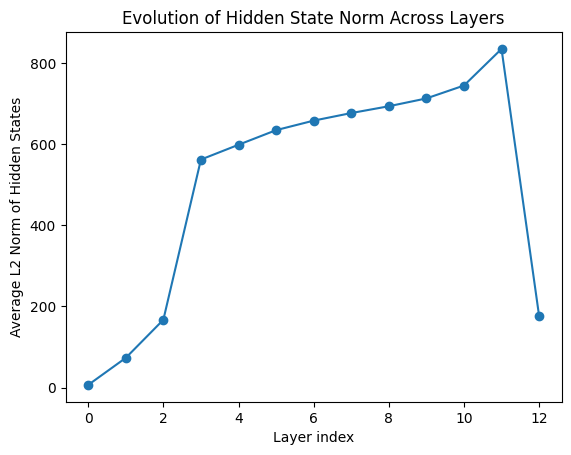

In [13]:
layer_norms = []
for i, hidden_state in enumerate(all_hidden_states):
    # hidden_state shape: [batch_size, seq_len, hidden_dim]
    # Let's say batch_size = 1
    # Compute L2 norm across the hidden_dim, then average across seq_len
    norms = hidden_state.norm(dim=-1).mean().item()
    layer_norms.append(norms)

plt.plot(range(len(layer_norms)), layer_norms, marker="o")
plt.xlabel("Layer index")
plt.ylabel("Average L2 Norm of Hidden States")
plt.title("Evolution of Hidden State Norm Across Layers")
plt.show()

This line plot shows how “strong” (in L2 sense) the hidden representations are at each layer. You may notice the norm grows or shrinks in certain layers, giving a rough idea of how the network transforms representations as you go deeper.

---

## 6. Next-Token Logits and Probabilities

The model's final linear layer (the LM head) converts the last hidden state into logits for each token in the vocabulary. Let's inspect the logits for the last token in the sequence.

In [9]:
# The logits are in outputs.logits with shape [batch_size, seq_len, vocab_size]
logits = outputs.logits
print("Logits shape:", logits.shape)

# Take the logits for the last token
last_token_logits = logits[0, -1, :]
print("Logits for the last token shape:", last_token_logits.shape)

# Convert logits to probabilities
probs = torch.nn.functional.softmax(last_token_logits, dim=-1)
top_k = 5
top_k_probs, top_k_indices = torch.topk(probs, top_k)

for i, (index, p) in enumerate(zip(top_k_indices, top_k_probs)):
    print(
        f"{i + 1}) Token: {tokenizer.decode(index.item())}, Probability: {p.item():.4f}"
    )

Logits shape: torch.Size([1, 5, 50257])
Logits for the last token shape: torch.Size([50257])
1) Token:  John, Probability: 0.0099
2) Token:  K, Probability: 0.0082
3) Token:  J, Probability: 0.0076
4) Token:  Michael, Probability: 0.0068
5) Token:  L, Probability: 0.0066


- **`outputs.logits`** has shape `(batch_size, sequence_length, vocab_size)`.
- We select `logits[0, -1, :]`, i.e., from the first (and only) batch, the final token in the sequence, and all possible vocabulary logits.
- Then we convert these logits to probabilities and extract the top-k probabilities and their corresponding tokens.

This shows which tokens the model finds most likely to follow the input text `"Hello, my name is"`.

---

## 7. Auto-Regressive Text Generation

To illustrate the auto-regressive nature, let's generate text token-by-token. We'll use a simple greedy approach, though you could also use beam search or sampling, which we will discuss later.

**Note**: This is just a brief demo of how tokens are generated one at a time. For more sophisticated text generation, use `model.generate()`.

In [10]:
generated_ids = input_ids.clone()
max_new_tokens = 20

model.eval()
with torch.no_grad():
    for _ in range(max_new_tokens):
        outputs = model(generated_ids, output_attentions=False)
        next_token_logits = outputs.logits[:, -1, :]
        # Greedy approach: pick the token with the highest logit
        next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # Append next token
        generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)

generated_text = tokenizer.decode(generated_ids[0])
print("Generated text:")
print(generated_text)

Generated text:
Hello, my name is John. I'm a writer, and I'm a writer. I'm a writer. I'm


The above output is repetitive because GPT-2 is a 124 million parameter model, which is small by today's standards. Likewise, the training techniques were less sophisticated in 2019 when it was released, so it is believed that the model is overfitted to its limited training dataset. We're also using greedly sampling to select the next token, which is leading to repetetive output. We could use some sampling techniques like Temperature, Top-P, and Top-K to create more varied output. We'll discuss these techniques in the next section.